## Libraries

In [1]:

import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno
import datetime as dt
import category_encoders as ce
from sklearn_features.transformers import DataFrameSelector
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
import joblib

### ***Helper funcation tom detect outliers***

In [7]:
def outlier_handle(data, col_list):
    df_new = data.copy()
    for col_name in col_list:
        q1 = data[col_name].quantile(0.25)
        q3 = data[col_name].quantile(0.75)
        iqr = q3-q1  #IQR
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_new.loc[:,  col_name] = np.where(data[col_name]> fence_high, fence_high,
                                         np.where(data[col_name]< fence_low, fence_low,
                                                  data[col_name]))
    return df_new

## Reading and Understanding the data

In [8]:
sns.set_style("darkgrid")
pd.options.display.float_format = '{:.3f}'.format

PATH='/mnt/3d37937b-ae66-4b53-9163-f354a1f3e7bc/Epsilon Ai sessions for data scenice/Data Science/CarPricePredictor/data_set/car_price_prediction.csv'

In [9]:
df=pd.read_csv(PATH)
df.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category   
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep  \
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders   
0              Yes    Hybrid           3.5  186005 km      6.000  \
1               No    Petrol             3  192000 km      6.000   
2               No    Petrol           1.3  200000 km      4.000   
3              Yes    Hybrid           2.5  168966 km      4.000   
4              Yes    Petrol           1.3   91901 km      4.000   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

In [10]:
df.shape

(19237, 18)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [12]:
df.rename(columns={'Prod. year':'year'},inplace=True)
df.head()

ID  Price  Levy Manufacturer    Model  year   Category   
0  45654403  13328  1399        LEXUS   RX 450  2010       Jeep  \
1  44731507  16621  1018    CHEVROLET  Equinox  2011       Jeep   
2  45774419   8467     -        HONDA      FIT  2006  Hatchback   
3  45769185   3607   862         FORD   Escape  2011       Jeep   
4  45809263  11726   446        HONDA      FIT  2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders   
0              Yes    Hybrid           3.5  186005 km      6.000  \
1               No    Petrol             3  192000 km      6.000   
2               No    Petrol           1.3  200000 km      4.000   
3              Yes    Hybrid           2.5  168966 km      4.000   
4              Yes    Petrol           1.3   91901 km      4.000   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

In [13]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

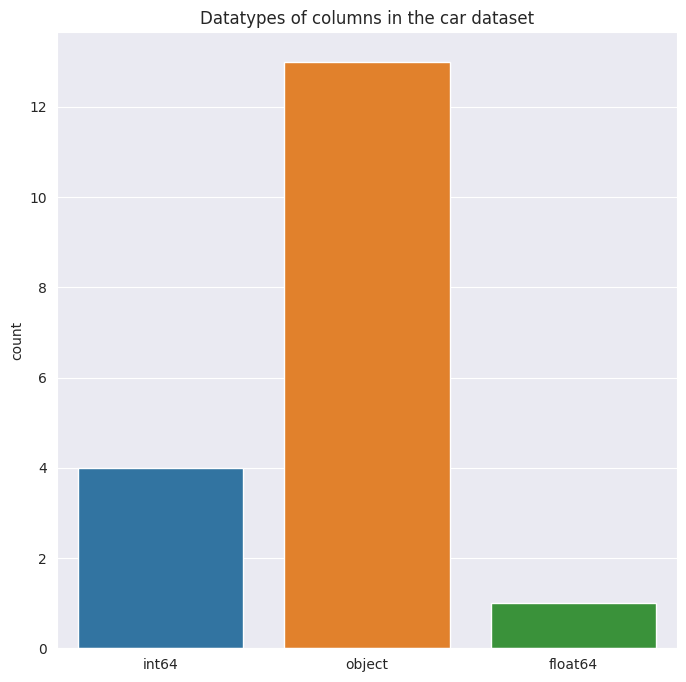

Count of the datatypes of columns
object     13
int64       4
float64     1
Name: count, dtype: int64


In [14]:
plt.figure(figsize=(8,8))
sns.countplot(x=df.dtypes)
plt.title("Datatypes of columns in the car dataset")
plt.show()
print("Count of the datatypes of columns")
print(df.dtypes.value_counts())

In [15]:
df.isnull().sum() #checking whether there are null values in the dataset

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
year                0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

<Axes: >

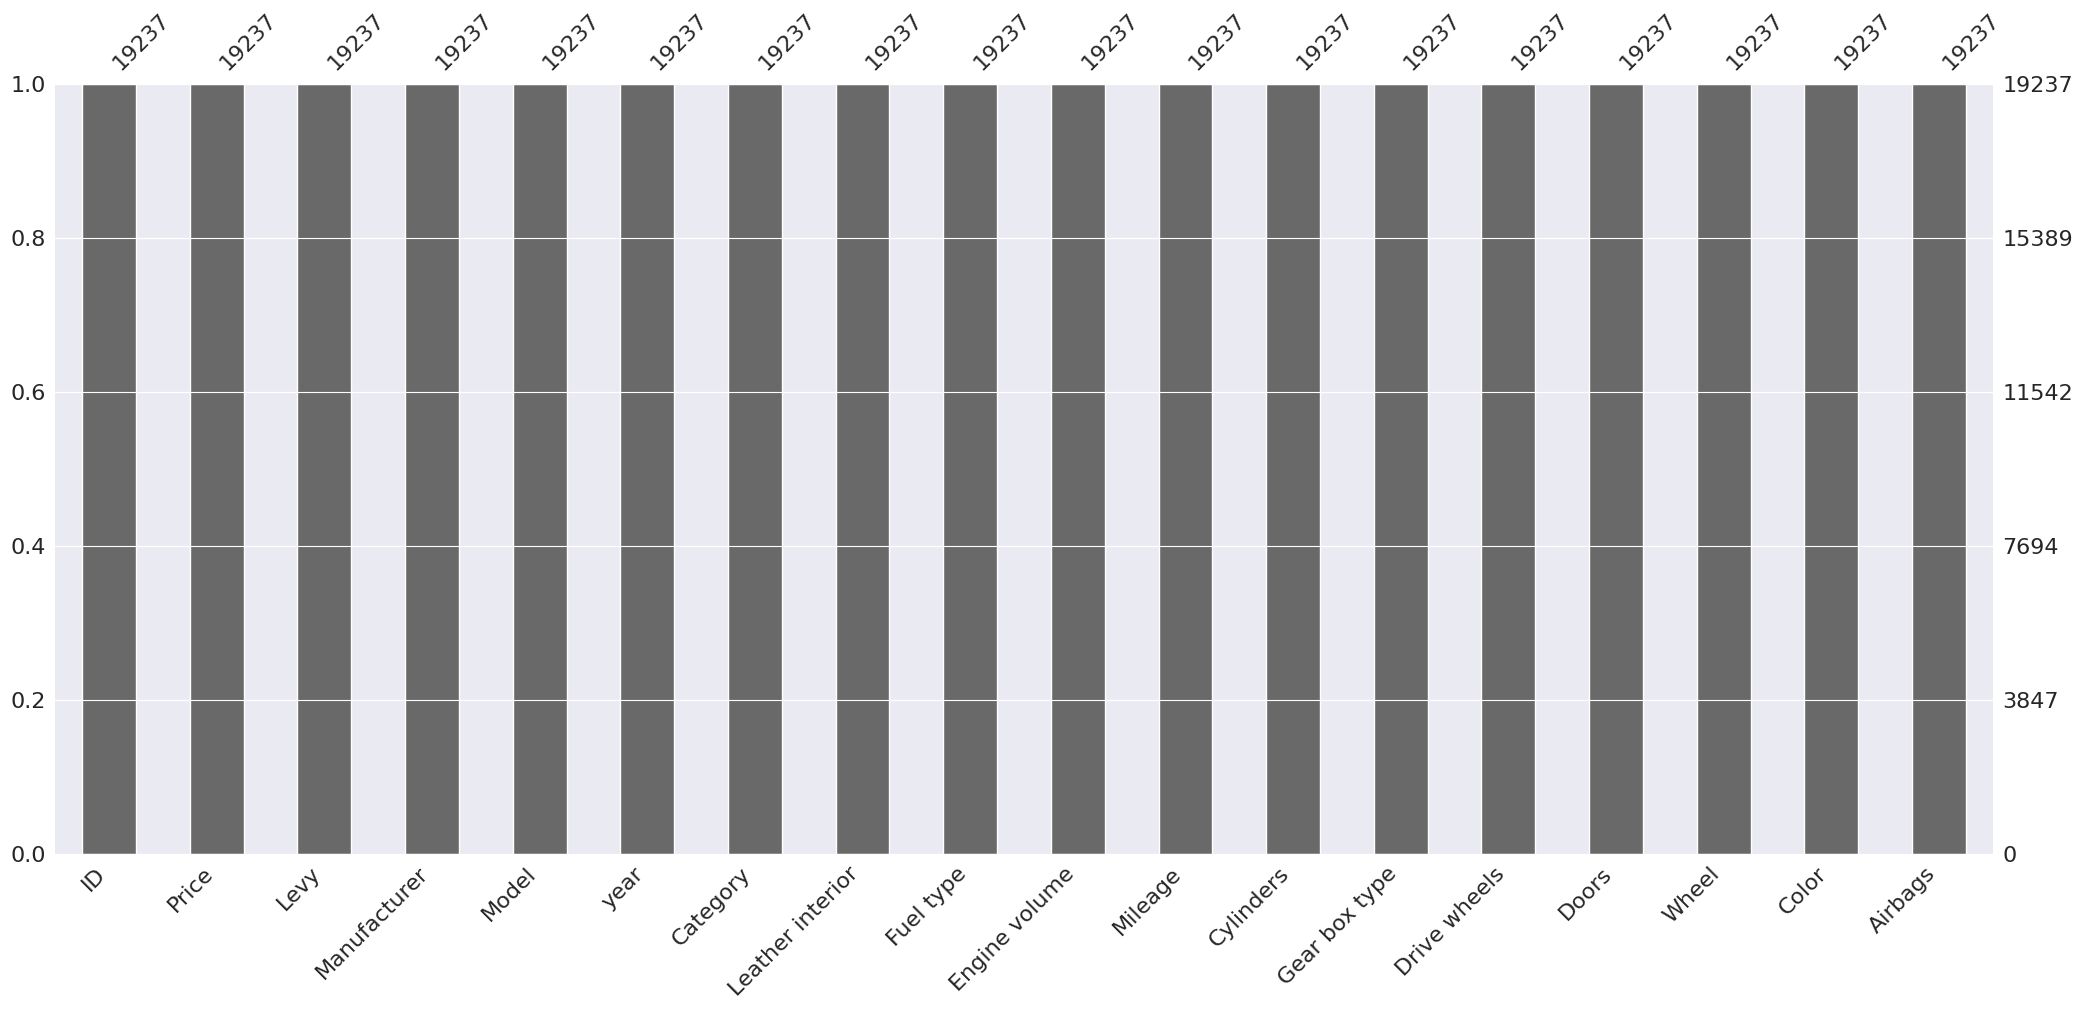

In [16]:
missingno.bar(df)

In [17]:
df.describe()

ID        Price      year  Cylinders   Airbags
count    19237.000    19237.000 19237.000  19237.000 19237.000
mean  45576535.886    18555.927  2010.913      4.583     6.583
std     936591.423   190581.270     5.669      1.200     4.320
min   20746880.000        1.000  1939.000      1.000     0.000
25%   45698374.000     5331.000  2009.000      4.000     4.000
50%   45772308.000    13172.000  2012.000      4.000     6.000
75%   45802036.000    22075.000  2015.000      4.000    12.000
max   45816654.000 26307500.000  2020.000     16.000    16.000

## Cleaning Data

In [18]:
df.columns=df.columns.str.lower().str.replace(" ","_")
df.head()

id  price  levy manufacturer    model  year   category   
0  45654403  13328  1399        LEXUS   RX 450  2010       Jeep  \
1  44731507  16621  1018    CHEVROLET  Equinox  2011       Jeep   
2  45774419   8467     -        HONDA      FIT  2006  Hatchback   
3  45769185   3607   862         FORD   Escape  2011       Jeep   
4  45809263  11726   446        HONDA      FIT  2014  Hatchback   

  leather_interior fuel_type engine_volume    mileage  cylinders   
0              Yes    Hybrid           3.5  186005 km      6.000  \
1               No    Petrol             3  192000 km      6.000   
2               No    Petrol           1.3  200000 km      4.000   
3              Yes    Hybrid           2.5  168966 km      4.000   
4              Yes    Petrol           1.3   91901 km      4.000   

  gear_box_type drive_wheels   doors             wheel   color  airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

In [19]:
df.shape

(19237, 18)

In [20]:
df.describe()

id        price      year  cylinders   airbags
count    19237.000    19237.000 19237.000  19237.000 19237.000
mean  45576535.886    18555.927  2010.913      4.583     6.583
std     936591.423   190581.270     5.669      1.200     4.320
min   20746880.000        1.000  1939.000      1.000     0.000
25%   45698374.000     5331.000  2009.000      4.000     4.000
50%   45772308.000    13172.000  2012.000      4.000     6.000
75%   45802036.000    22075.000  2015.000      4.000    12.000
max   45816654.000 26307500.000  2020.000     16.000    16.000

In [21]:
df.duplicated().sum() # to find the number of duplicate rows

313

In [22]:
df.loc[df.duplicated()]

id  price  levy   manufacturer        model  year   category   
425    45815372   7840     -  MERCEDES-BENZ        E 200  1998      Sedan  \
1581   45815363   8781     -         TOYOTA          Ist  2002  Hatchback   
1697   45732125  18503     -         TOYOTA        Prius  2010      Sedan   
1972   45507765  20385     -  MERCEDES-BENZ      CLS 500  2005      Sedan   
2131   45815363   8781     -         TOYOTA          Ist  2002  Hatchback   
...         ...    ...   ...            ...          ...   ...        ...   
18974  45815465   2352  1273          LEXUS       IS 350  2015      Sedan   
19137  45810466  15125   642      CHEVROLET      Orlando  2012       Jeep   
19200  45725908  36065   640  MERCEDES-BENZ  CLA 250 AMG  2013      Sedan   
19203  45761487  13485   645         TOYOTA        Prius  2011      Sedan   
19210  45732939   8311   642        HYUNDAI       Sonata  2012      Sedan   

      leather_interior fuel_type engine_volume    mileage  cylinders   
425                 No       CNG             2  180003 km      4.000  \
1581                No    Petrol           1.5  117000 km      4.000   
1697                No    Petrol           1.8  162000 km      4.000   
1972               Yes    Petrol             5  230000 km      8.000   
2131                No    Petrol           1.5  117000 km      4.000   
...                ...       ...           ...        ...        ...   
18974              Yes    Petrol           3.5   80856 km      6.000   
19137              Yes    Diesel             2  156834 km      4.000   
19200              Yes    Petrol     2.0 Turbo   68000 km      4.000   
19203               No    Hybrid           1.8  281600 km      6.000   
19210              Yes       LPG             2   36545 km      4.000   

      gear_box_type drive_wheels   doors             wheel   color  airbags  
425          Manual         Rear  04-May        Left wheel   Black        4  
1581      Automatic          4x4  04-May  Right-hand drive     Red        4  
1697      Automatic        Front  04-May        Left wheel    Grey       12  
1972      Tiptronic         Rear  04-May        Left wheel  Silver       10  
2131      Automatic          4x4  04-May  Right-hand drive     Red        4  
...             ...          ...     ...               ...     ...      ...  
18974     Automatic          4x4  04-May        Left wheel   Black       12  
19137     Automatic        Front  04-May        Left wheel  Golden        4  
19200     Tiptronic        Front  04-May        Left wheel     Red       12  
19203     Automatic        Front  04-May        Left wheel    Grey        8  
19210     Automatic        Front  04-May        Left wheel   White        4  

[313 rows x 18 columns]

In [23]:
df.drop_duplicates(inplace = True)
df.drop('id',axis = 1,inplace = True)
print(f'This DataSet Contains {df.shape[0]} rows & {df.shape[1]} columns.')
df.shape

This DataSet Contains 18924 rows & 17 columns.


(18924, 17)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             18924 non-null  int64  
 1   levy              18924 non-null  object 
 2   manufacturer      18924 non-null  object 
 3   model             18924 non-null  object 
 4   year              18924 non-null  int64  
 5   category          18924 non-null  object 
 6   leather_interior  18924 non-null  object 
 7   fuel_type         18924 non-null  object 
 8   engine_volume     18924 non-null  object 
 9   mileage           18924 non-null  object 
 10  cylinders         18924 non-null  float64
 11  gear_box_type     18924 non-null  object 
 12  drive_wheels      18924 non-null  object 
 13  doors             18924 non-null  object 
 14  wheel             18924 non-null  object 
 15  color             18924 non-null  object 
 16  airbags           18924 non-null  int64  
dty

## Columns in the dataset:

In [25]:
df.columns

Index(['price', 'levy', 'manufacturer', 'model', 'year', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags'],
      dtype='object')

### Doors

In [26]:
df['doors']

0        04-May
1        04-May
2        04-May
3        04-May
4        04-May
          ...  
19232    02-Mar
19233    04-May
19234    04-May
19235    04-May
19236    04-May
Name: doors, Length: 18924, dtype: object

In [27]:
df['doors'].value_counts()

doors
04-May    18032
02-Mar      768
>5          124
Name: count, dtype: int64

In [28]:
#replacing the dates with the number of doors present in the car
df['doors'] = df['doors'].str.replace('04-May','4-5')
df['doors'] = df['doors'].str.replace('02-Mar','2-3')
df['doors'].value_counts()

doors
4-5    18032
2-3      768
>5       124
Name: count, dtype: int64

### Levy

In [29]:
df['levy']

0        1399
1        1018
2           -
3         862
4         446
         ... 
19232       -
19233     831
19234     836
19235    1288
19236     753
Name: levy, Length: 18924, dtype: object

In [30]:
#  replace '-' with '0'
df['levy'] = df['levy'].replace(['-'],['0'])
df['levy'] = df['levy'].astype(str).astype(int)
df['levy']

0        1399
1        1018
2           0
3         862
4         446
         ... 
19232       0
19233     831
19234     836
19235    1288
19236     753
Name: levy, Length: 18924, dtype: int64

### Engine Volume

In [31]:
df['engine_volume']

0              3.5
1                3
2              1.3
3              2.5
4              1.3
           ...    
19232    2.0 Turbo
19233          2.4
19234            2
19235            2
19236          2.4
Name: engine_volume, Length: 18924, dtype: object

In [32]:
df['engine_volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

In [33]:
df['engine_volume'].value_counts()

engine_volume
2            3856
2.5          2246
1.8          1743
1.6          1446
1.5          1289
             ... 
6.8             1
6.7             1
3.1             1
0.8 Turbo       1
1.1 Turbo       1
Name: count, Length: 107, dtype: int64

In [34]:
# Remove the string 'Turbo'.
# Convert the datatype of the column from object to float.
df['engine_turbo'] = df['engine_volume'].str.contains("Turbo").map({False:0,True:1})
df['engine_volume']=df['engine_volume'].str.replace('Turbo','')
df['engine_volume']= df['engine_volume'].astype(str).astype(float)
df['engine_volume']

0       3.500
1       3.000
2       1.300
3       2.500
4       1.300
         ... 
19232   2.000
19233   2.400
19234   2.000
19235   2.000
19236   2.400
Name: engine_volume, Length: 18924, dtype: float64

In [35]:
df['engine_turbo']

0        0
1        0
2        0
3        0
4        0
        ..
19232    1
19233    0
19234    0
19235    0
19236    0
Name: engine_turbo, Length: 18924, dtype: int64

###  Mileage

In [36]:
df['mileage']

0        186005 km
1        192000 km
2        200000 km
3        168966 km
4         91901 km
           ...    
19232    300000 km
19233    161600 km
19234    116365 km
19235     51258 km
19236    186923 km
Name: mileage, Length: 18924, dtype: object

In [37]:
# Remove the string 'KM'.
# Convert it to 'int' datatype.

df['mileage']=df['mileage'].str.replace('km','')
df['mileage']= df['mileage'].astype(str).astype(int)
df['mileage']

0        186005
1        192000
2        200000
3        168966
4         91901
          ...  
19232    300000
19233    161600
19234    116365
19235     51258
19236    186923
Name: mileage, Length: 18924, dtype: int64

### Price

In [38]:
df[df['price']<=300]

price  levy manufacturer       model  year   category leather_interior   
27        30     0       TOYOTA       Prius  2008      Sedan               No  \
33       125  1750       TOYOTA  Highlander  2008      Sedan              Yes   
45       220  1194       TOYOTA      Tacoma  2013       Jeep              Yes   
79       220  1185         FORD      Escape  2009       Jeep              Yes   
117       94     0        HONDA         FIT  2003  Hatchback               No   
...      ...   ...          ...         ...   ...        ...              ...   
19103     30     0       NISSAN       Tiida  2006  Hatchback               No   
19148     30     0        HONDA         FIT  2005  Hatchback               No   
19164     60     0       TOYOTA       Prius  2013      Sedan               No   
19218     30     0       NISSAN        Note  2006  Hatchback               No   
19229     50     0       TOYOTA       Prius  2008  Hatchback               No   

      fuel_type  engine_volume  mileage  cylinders gear_box_type drive_wheels   
27       Hybrid          1.500   169000      4.000     Automatic        Front  \
33       Hybrid          3.300   287274      6.000     Automatic          4x4   
45       Petrol          4.000   239342      6.000     Automatic          4x4   
79       Hybrid          2.500   193614      4.000     Automatic        Front   
117      Petrol          1.500   178000      4.000      Variator        Front   
...         ...            ...      ...        ...           ...          ...   
19103    Petrol          1.500        0      4.000     Automatic        Front   
19148    Petrol          1.300   169000      4.000     Automatic        Front   
19164    Hybrid          1.800   150000      4.000     Automatic        Front   
19218    Petrol          1.300        0      4.000     Automatic        Front   
19229    Hybrid          1.500   150000      4.000     Automatic        Front   

      doors             wheel   color  airbags  engine_turbo  
27      4-5        Left wheel   White        8             0  
33      4-5        Left wheel   White       12             0  
45      4-5        Left wheel  Silver       12             0  
79      4-5        Left wheel   White        0             0  
117     4-5  Right-hand drive  Silver        4             0  
...     ...               ...     ...      ...           ...  
19103   4-5  Right-hand drive   Black        4             0  
19148   4-5  Right-hand drive   White        4             0  
19164   4-5        Left wheel   White        8             0  
19218   4-5  Right-hand drive   Green        9             0  
19229   4-5        Left wheel  Silver        6             0  

[888 rows x 18 columns]

**Most Cars Under 300$ in price has age less than 20 and this non realistice Price for car with this age**


In [39]:
df = df[df['price']>=300]

## Handle Outliers

In [40]:
num_cols=df.select_dtypes(include='number')
num_cols

price  levy  year  engine_volume  mileage  cylinders  airbags   
0      13328  1399  2010          3.500   186005      6.000       12  \
1      16621  1018  2011          3.000   192000      6.000        8   
2       8467     0  2006          1.300   200000      4.000        2   
3       3607   862  2011          2.500   168966      4.000        0   
4      11726   446  2014          1.300    91901      4.000        4   
...      ...   ...   ...            ...      ...        ...      ...   
19232   8467     0  1999          2.000   300000      4.000        5   
19233  15681   831  2011          2.400   161600      4.000        8   
19234  26108   836  2010          2.000   116365      4.000        4   
19235   5331  1288  2007          2.000    51258      4.000        4   
19236    470   753  2012          2.400   186923      4.000       12   

       engine_turbo  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
19232             1  
19233             0  
19234             0  
19235             0  
19236             0  

[18042 rows x 8 columns]

/tmp/ipykernel_35991/312161362.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[0],color='red').set(title="Distplot")
/tmp/ipykernel_35991/312161362.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_35991/312161362.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to u

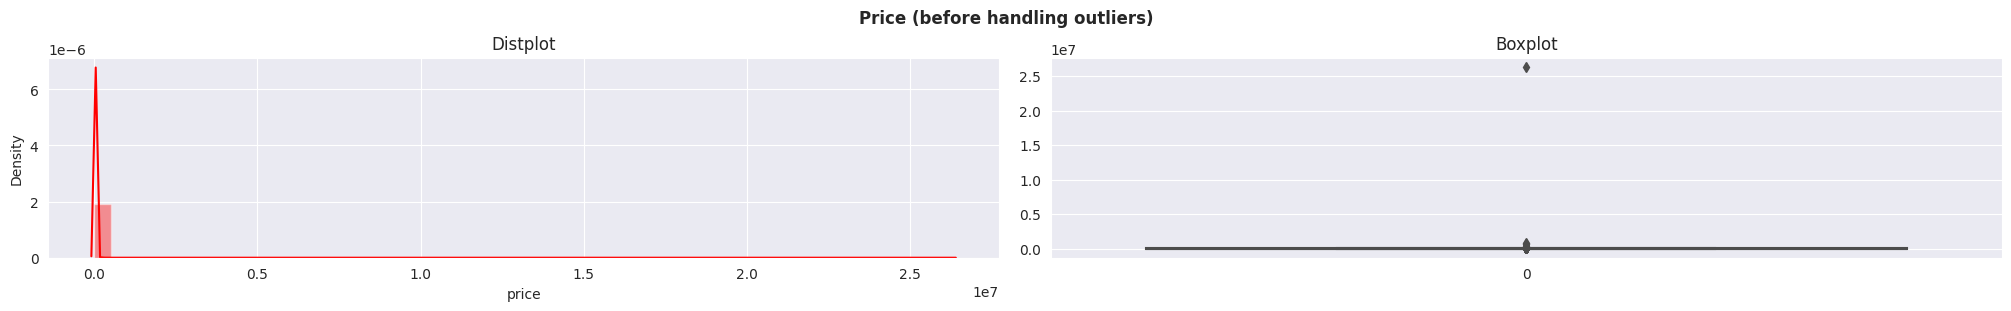

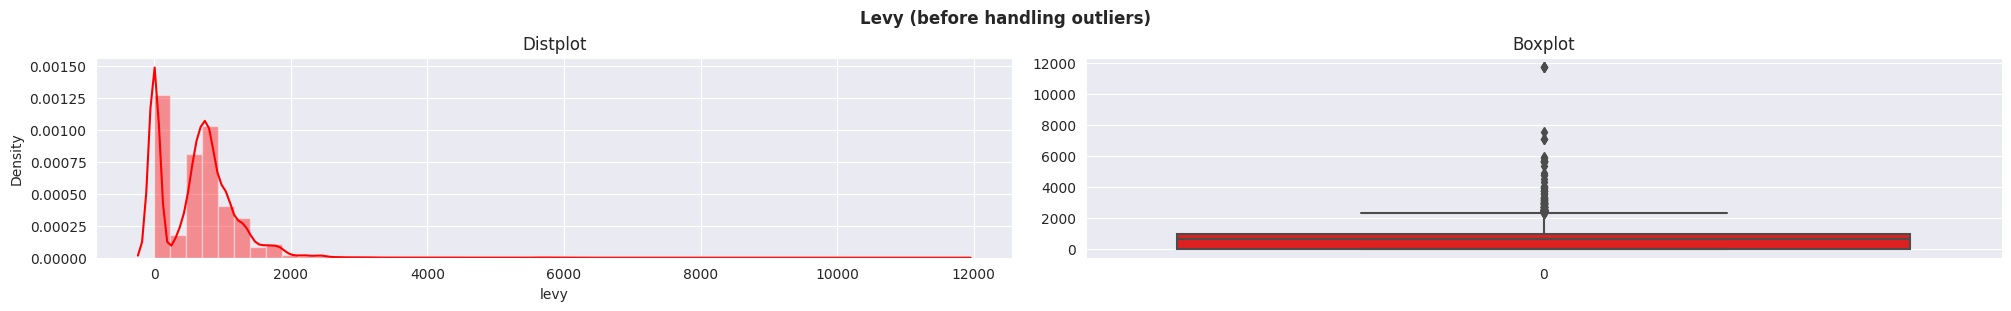

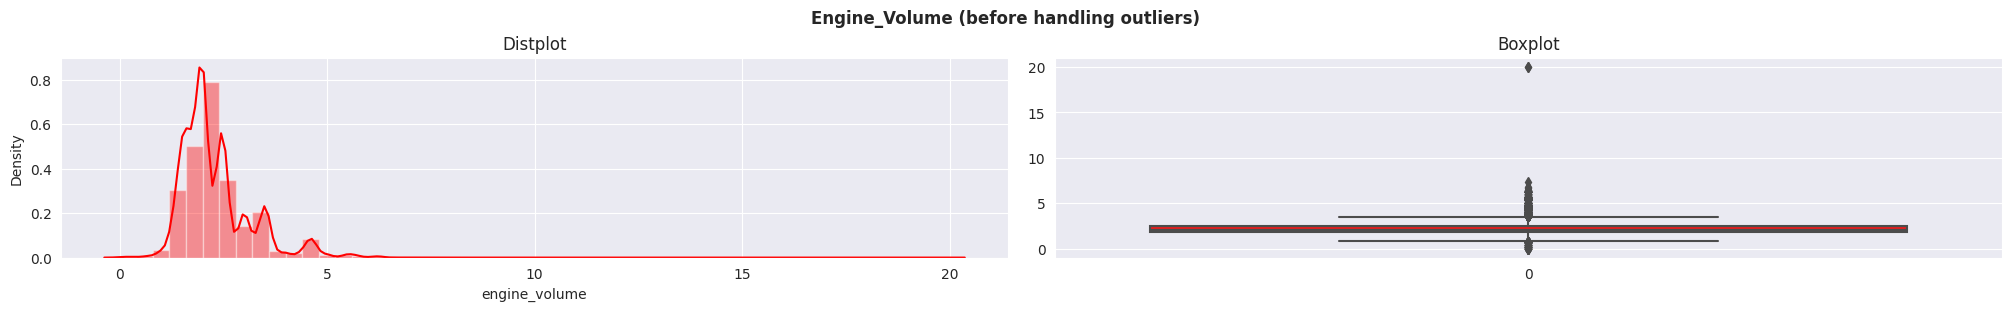

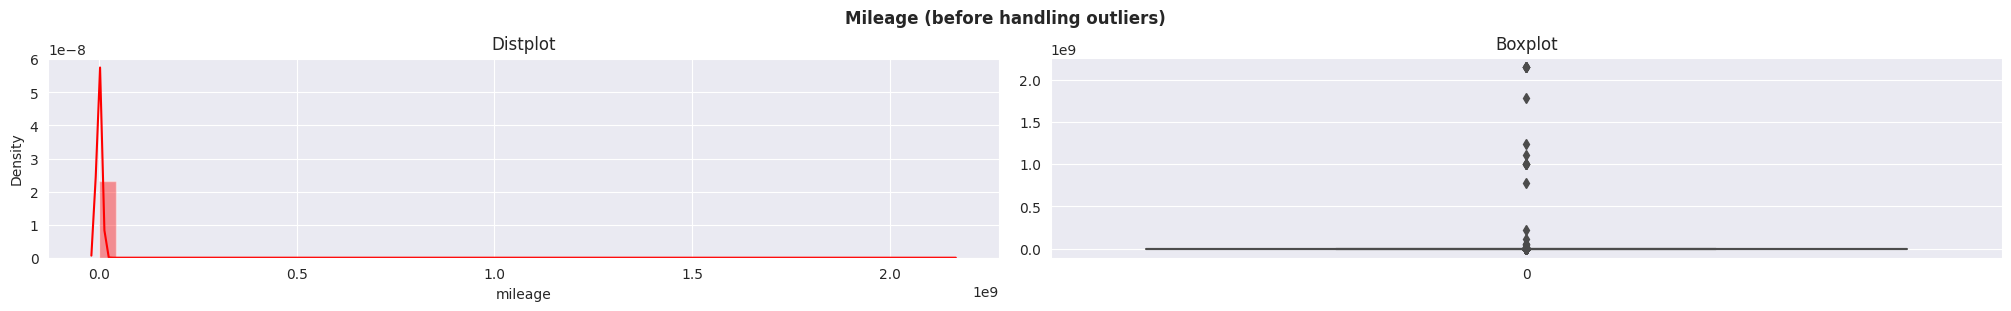

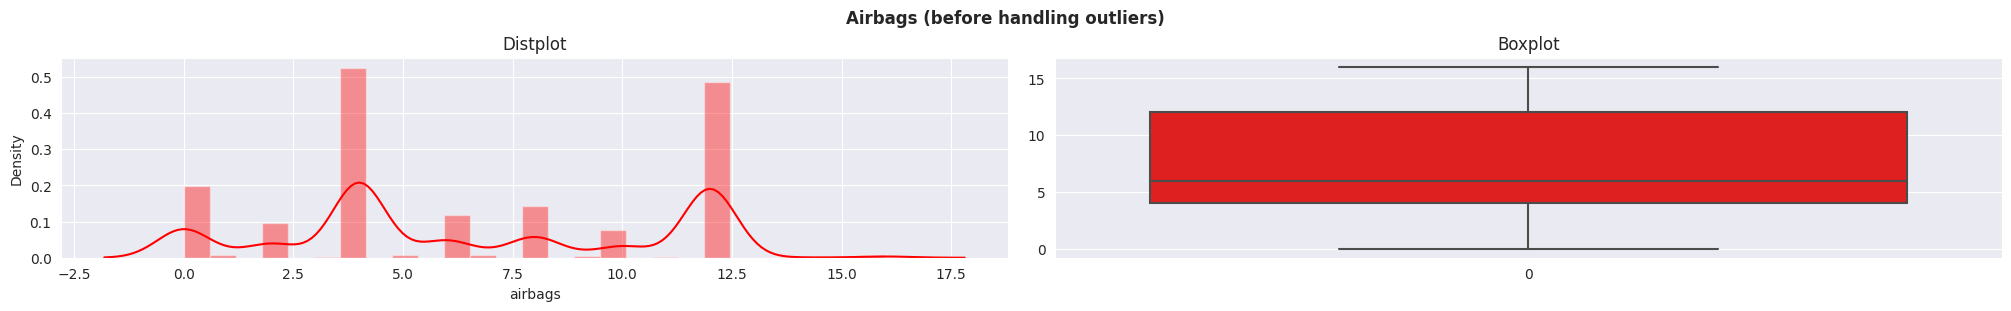

In [41]:
cont_col = ['price', 'levy',  'engine_volume', 'mileage', 'airbags']
for col in cont_col:
    fig, ax =plt.subplots(1,2, constrained_layout=True)
    fig.set_size_inches(20, 3)
    sns.distplot(df[col], ax=ax[0],color='red').set(title="Distplot")
    sns.boxplot(df[col], ax=ax[1],color='red').set(title="Boxplot")
    plt.suptitle(f'{col.title()} (before handling outliers)',weight='bold')
    fig.show()

In [42]:
df[cont_col].describe()

price      levy  engine_volume        mileage   airbags
count    18042.000 18042.000      18042.000      18042.000 18042.000
mean     19489.310   634.710          2.302    1441963.183     6.572
std     196731.862   566.141          0.869   46631261.812     4.277
min        300.000     0.000          0.000          0.000     0.000
25%       6586.000     0.000          1.800      70000.000     4.000
50%      13877.000   642.000          2.000     125126.000     6.000
75%      22894.000   915.000          2.500     187087.000    12.000
max   26307500.000 11714.000         20.000 2147483647.000    16.000

In [43]:
def outlier_prcnt(data, col_list):
    for col_name in col_list:
        q1 = data[col_name].quantile(0.25)
        q3 = data[col_name].quantile(0.75)
        iqr = q3-q1  #IQR
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr

        
        outliers = ((data[col_name] > fence_high) | (data[col_name] < fence_low)).sum()
        total = data[col_name].shape[0]
        print(f"Total outliers in {col_name} are: {outliers} - {round(100*(outliers)/total,2)}%.")

outlier_prcnt(df, cont_col)

Total outliers in price are: 1043 - 5.78%.
Total outliers in levy are: 144 - 0.8%.
Total outliers in engine_volume are: 1265 - 7.01%.
Total outliers in mileage are: 646 - 3.58%.
Total outliers in airbags are: 0 - 0.0%.


In [44]:
def outlier_handle(data, col_list):
    df_new = data.copy()
    for col_name in col_list:
        q1 = data[col_name].quantile(0.25)
        q3 = data[col_name].quantile(0.75)
        iqr = q3-q1  #IQR
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_new.loc[:,  col_name] = np.where(data[col_name]> fence_high, fence_high,
                                         np.where(data[col_name]< fence_low, fence_low,
                                                  data[col_name]))
    return df_new
df = outlier_handle(df, cont_col)

/tmp/ipykernel_35991/2537538318.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[0],color='red').set(title="Distplot")
/tmp/ipykernel_35991/2537538318.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_35991/2537538318.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code t

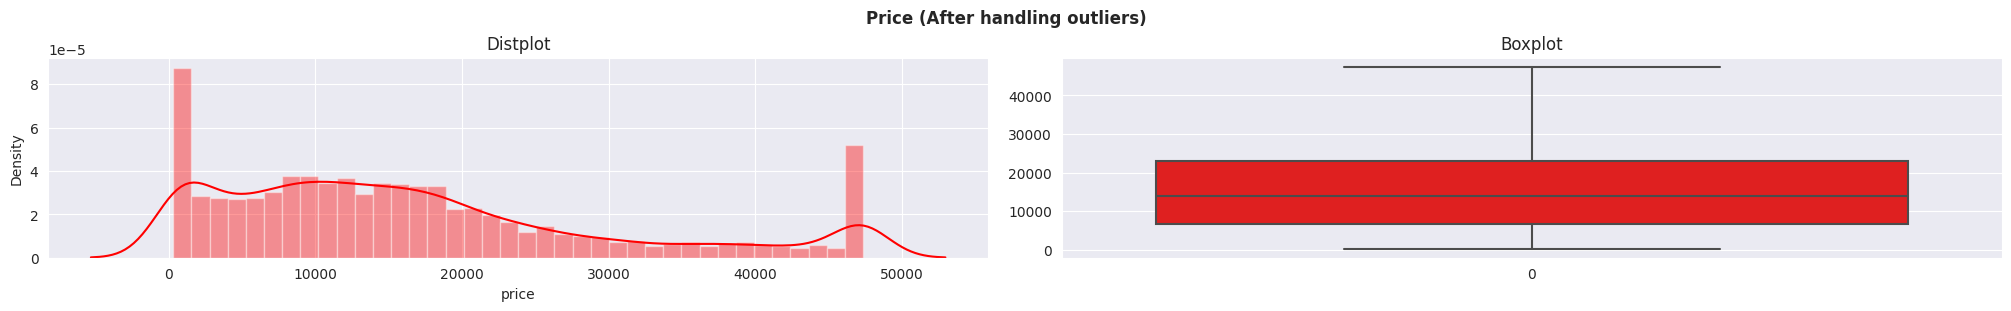

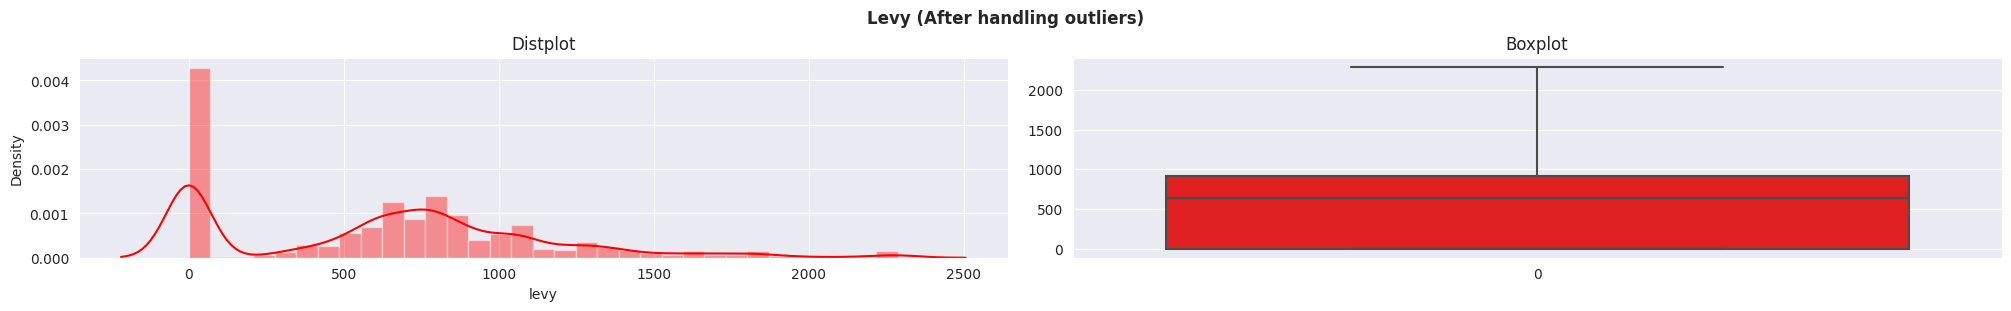

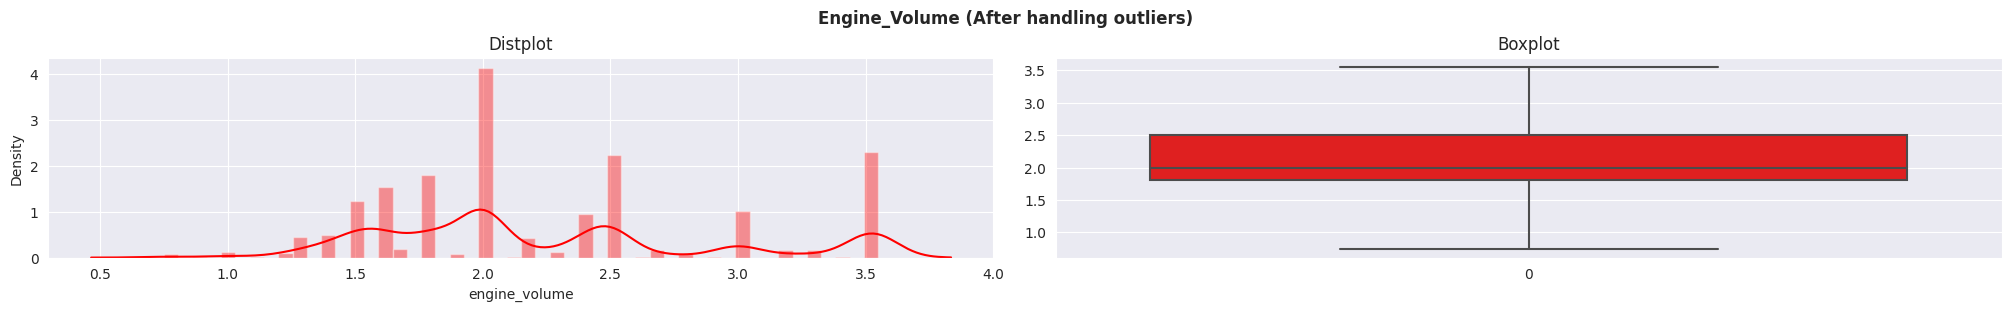

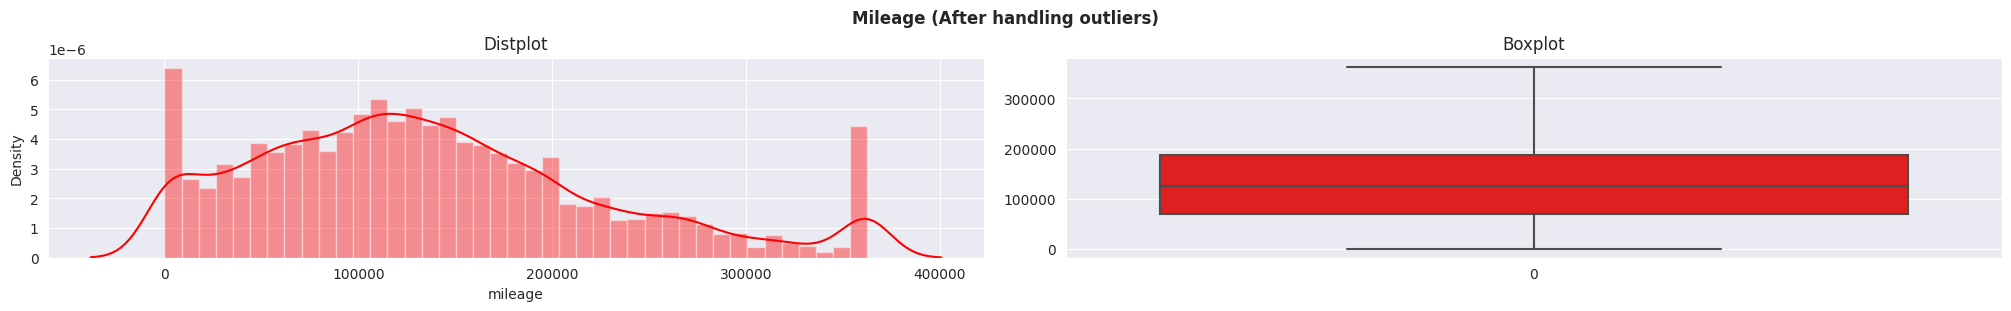

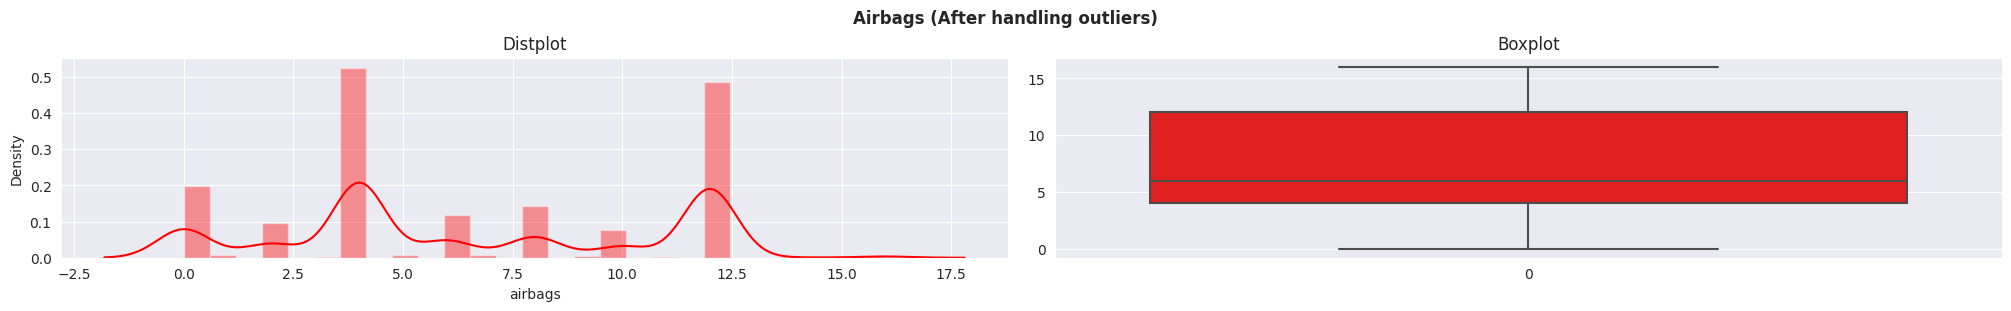

In [45]:
for col in cont_col:
    fig, ax =plt.subplots(1,2, constrained_layout=True)
    fig.set_size_inches(20, 3)
    sns.distplot(df[col], ax=ax[0],color='red').set(title="Distplot")
    sns.boxplot(df[col], ax=ax[1],color='red').set(title="Boxplot")
    plt.suptitle(f'{col.title()} (After handling outliers)',weight='bold')
    fig.show()

## Exploratory Data Analysis:

### Univariate Analysis:

#### engine_volume

In [46]:
df['engine_volume'].value_counts().sort_values(ascending=False).head(10)

engine_volume
2.000    4174
2.500    2262
1.800    1823
1.600    1545
1.500    1239
3.550    1199
3.500    1119
3.000    1015
2.400     954
1.400     499
Name: count, dtype: int64

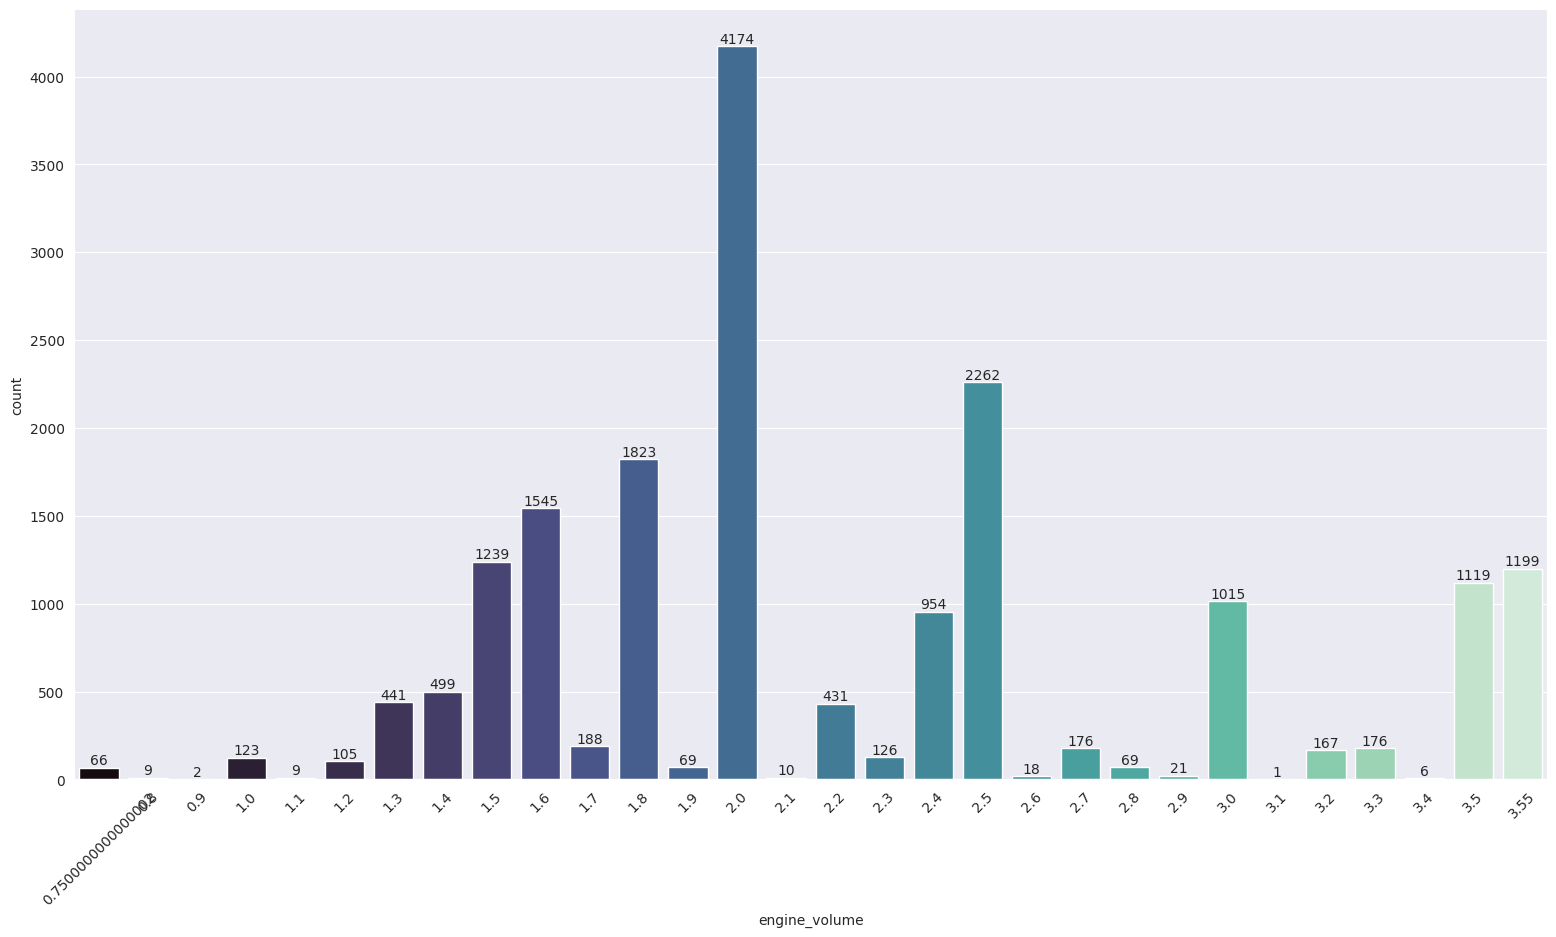

In [47]:
plt.figure(figsize=(19,10))
c1=sns.countplot(x='engine_volume',data=df,palette="mako")
plt.xticks(rotation=45)
c1.bar_label(c1.containers[0],size = 10)
plt.show()

* Majority of the cars produced has a 2L engine volume.

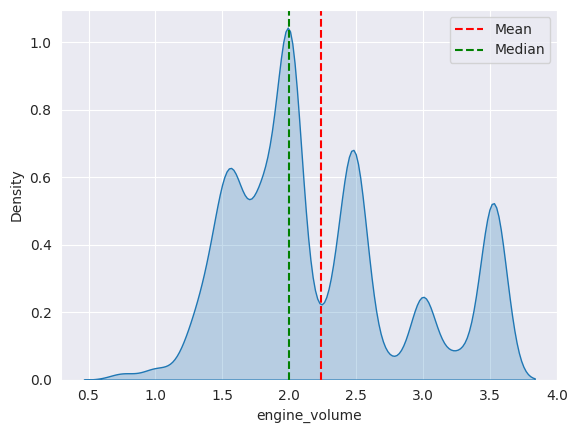

In [48]:
sns.kdeplot(data=df,x='engine_volume',fill=True)
plt.axvline(np.mean(df['engine_volume']), linestyle='--', c='r', label="Mean")
plt.axvline(np.median(df['engine_volume']), linestyle='--', c='g', label="Median")
plt.legend()
plt.show()

#### Turbo

In [49]:
turbo_values=df['engine_turbo'].value_counts()
turbo_values

engine_turbo
0    16181
1     1861
Name: count, dtype: int64

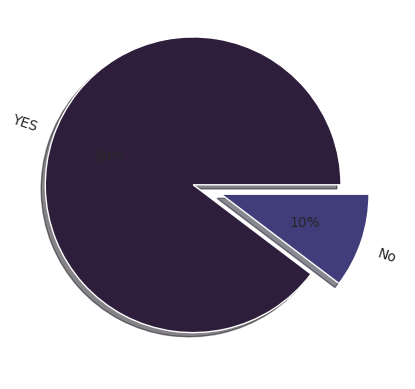

In [50]:
explode = [ 0.2, 0]
location = ['YES', 'No' ]

plt.pie(turbo_values, labels=location, colors=sns.color_palette('mako'),
        autopct='%.0f%%', explode=explode, shadow=True, rotatelabels='true')
plt.show()

#### Mileage

In [51]:
df.mileage

0       186005.000
1       192000.000
2       200000.000
3       168966.000
4        91901.000
           ...    
19232   300000.000
19233   161600.000
19234   116365.000
19235    51258.000
19236   186923.000
Name: mileage, Length: 18042, dtype: float64

In [52]:
df.mileage.describe()

count    18042.000
mean    136726.389
std      90116.688
min          0.000
25%      70000.000
50%     125126.000
75%     187087.000
max     362717.500
Name: mileage, dtype: float64

In [53]:
Mileage = df.mileage.value_counts().head(20)
Mileage

mileage
362717.500    646
0.000         638
200000.000    166
150000.000    132
160000.000    116
180000.000    109
170000.000     94
1000.000       94
120000.000     90
100000.000     87
130000.000     80
111111.000     78
190000.000     71
140000.000     70
300000.000     67
250000.000     66
110000.000     58
90000.000      57
80000.000      57
145000.000     56
Name: count, dtype: int64

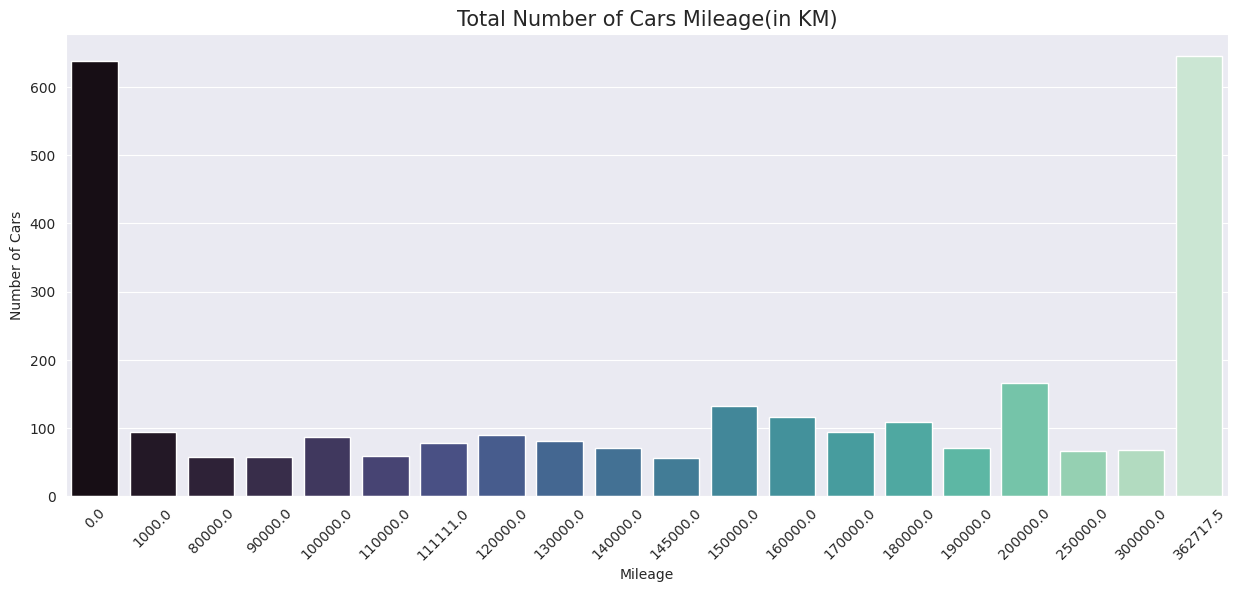

In [54]:
plt.figure(figsize=(15,6))
plt.title('Total Number of Cars Mileage(in KM)',fontsize=15)
c1=sns.barplot(x=Mileage.index,y=Mileage,palette="mako")
c1.set(xlabel='Mileage', ylabel='Number of Cars',)
plt.xticks(rotation=45)
plt.show()

#### Cylinders

In [55]:
df['cylinders']

0       6.000
1       6.000
2       4.000
3       4.000
4       4.000
         ... 
19232   4.000
19233   4.000
19234   4.000
19235   4.000
19236   4.000
Name: cylinders, Length: 18042, dtype: float64

In [56]:
df['cylinders'].value_counts()

cylinders
4.000     13593
6.000      3140
8.000       909
5.000       162
3.000       107
2.000        39
1.000        36
12.000       36
10.000       11
16.000        5
7.000         2
9.000         1
14.000        1
Name: count, dtype: int64

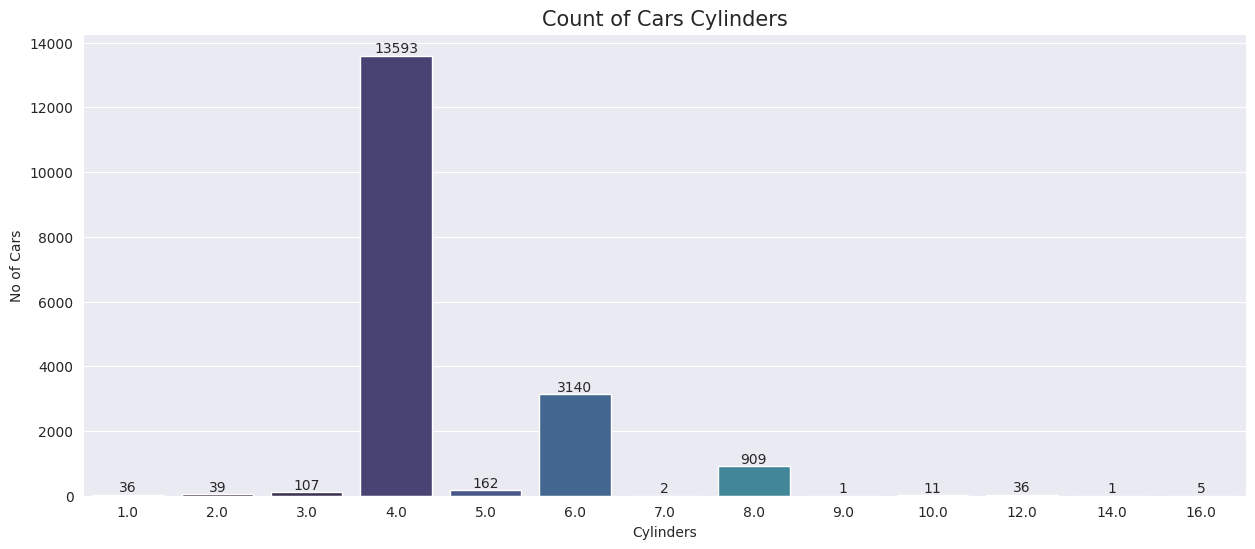

In [57]:
plt.figure(figsize=(15,6))
plt.title('Count of Cars Cylinders',fontsize=15)
c1=sns.countplot(x='cylinders',data=df,palette="mako")
c1.set(xlabel='Cylinders', ylabel='No of Cars')
c1.bar_label(c1.containers[0],size = 10)
plt.show()

* cllinders of 4 is the most frequency

#### Airbags

In [58]:
df['airbags']

0        12
1         8
2         2
3         0
4         4
         ..
19232     5
19233     8
19234     4
19235     4
19236    12
Name: airbags, Length: 18042, dtype: int64

In [59]:
df['airbags'].unique()

array([12,  8,  2,  0,  4,  6, 10,  3,  1, 16,  5,  7,  9, 11, 14, 15, 13])

In [60]:
df['airbags'].value_counts()

airbags
4     5622
12    5180
0     2131
8     1519
6     1248
2     1018
10     832
5       93
16      91
7       81
1       74
9       59
3       35
11      31
14      20
15       7
13       1
Name: count, dtype: int64

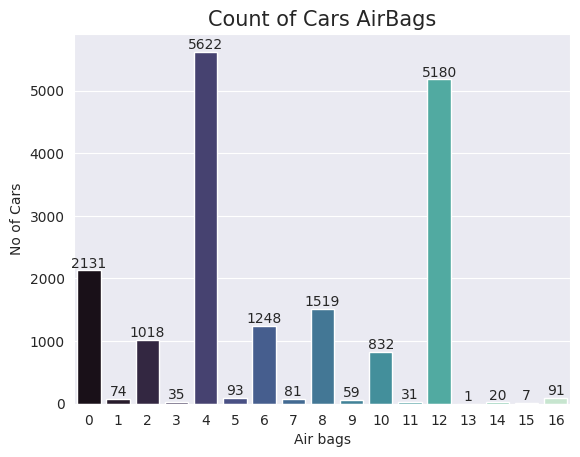

In [61]:
plt.title('Count of Cars AirBags',fontsize=15)
c1=sns.countplot(x='airbags',data=df,palette="mako")
c1.set(xlabel='Air bags', ylabel='No of Cars')
c1.bar_label(c1.containers[0],size = 10)
plt.show()

### Categorical Features

In [62]:
print("Categorical Variables:")
print(df.select_dtypes("object").columns.tolist())

Categorical Variables:
['manufacturer', 'model', 'category', 'leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color']


#### manufacturer

In [63]:
df['manufacturer']

0                LEXUS
1            CHEVROLET
2                HONDA
3                 FORD
4                HONDA
             ...      
19232    MERCEDES-BENZ
19233          HYUNDAI
19234          HYUNDAI
19235        CHEVROLET
19236          HYUNDAI
Name: manufacturer, Length: 18042, dtype: object

In [64]:
df['manufacturer'].unique()

array(['LEXUS', 'CHEVROLET', 'HONDA', 'FORD', 'HYUNDAI', 'TOYOTA',
       'MERCEDES-BENZ', 'OPEL', 'PORSCHE', 'BMW', 'JEEP', 'VOLKSWAGEN',
       'AUDI', 'RENAULT', 'NISSAN', 'SUBARU', 'DAEWOO', 'KIA',
       'MITSUBISHI', 'SSANGYONG', 'MAZDA', 'GMC', 'FIAT', 'INFINITI',
       'ALFA ROMEO', 'SUZUKI', 'ACURA', 'LINCOLN', 'VAZ', 'GAZ',
       'CITROEN', 'LAND ROVER', 'MINI', 'DODGE', 'CHRYSLER', 'JAGUAR',
       'ISUZU', 'SKODA', 'DAIHATSU', 'BUICK', 'TESLA', 'CADILLAC',
       'PEUGEOT', 'BENTLEY', 'VOLVO', 'სხვა', 'HAVAL', 'HUMMER', 'SCION',
       'UAZ', 'MERCURY', 'ZAZ', 'ROVER', 'SEAT', 'LANCIA', 'MOSKVICH',
       'MASERATI', 'FERRARI', 'SAAB', 'LAMBORGHINI', 'PONTIAC', 'SATURN',
       'ASTON MARTIN', 'GREATWALL'], dtype=object)

In [65]:
Manufacture=df['manufacturer'].value_counts().head(20)

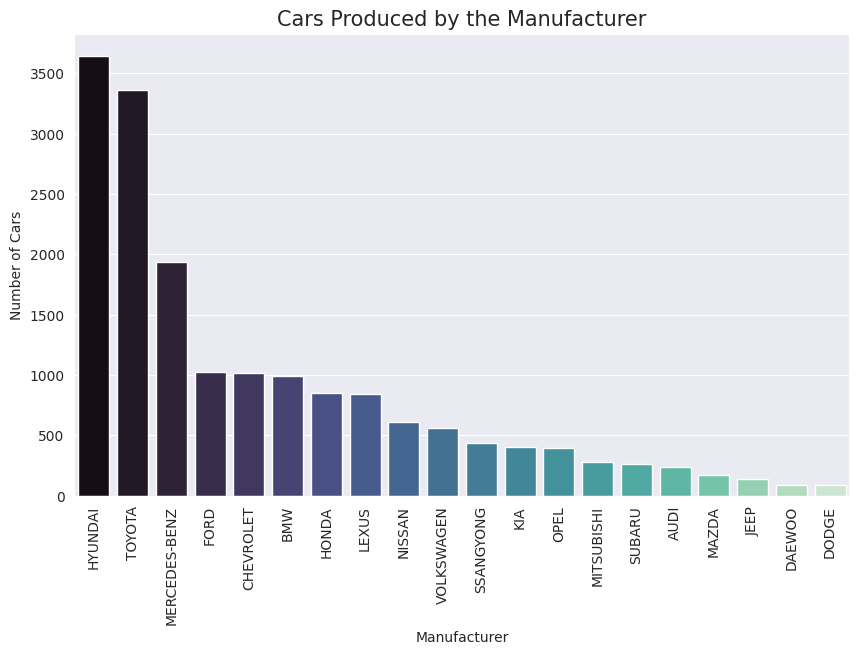

In [66]:
plt.figure(figsize=(10,6))
plt.tight_layout(pad=3)
plt.title("Cars Produced by the Manufacturer",fontsize=15)
sns.set_style("darkgrid")
a=sns.barplot(x=Manufacture.index,y=Manufacture,palette="mako")
a.set_xticklabels(Manufacture.index ,rotation=90)
a.set(xlabel='Manufacturer', ylabel='Number of Cars')
plt.show()

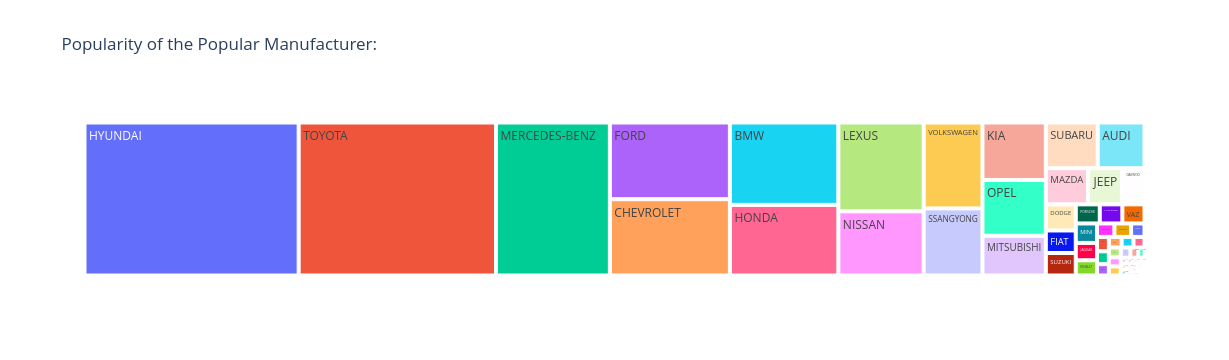

In [67]:
ax2= px.treemap(df,path=["manufacturer"],title="Popularity of the Popular Manufacturer:")
ax2.show()

#### Model

In [68]:
Model=df['model'].value_counts().head(20)
Model

model
Sonata        1019
Prius          960
Camry          888
Elantra        884
Santa FE       523
E 350          507
H1             435
Tucson         423
FIT            358
X5             319
Aqua           307
Cruze          292
Fusion         269
Optima         222
GX 460         205
Transit        205
Highlander     196
Jetta          195
Actyon         188
Civic          180
Name: count, dtype: int64

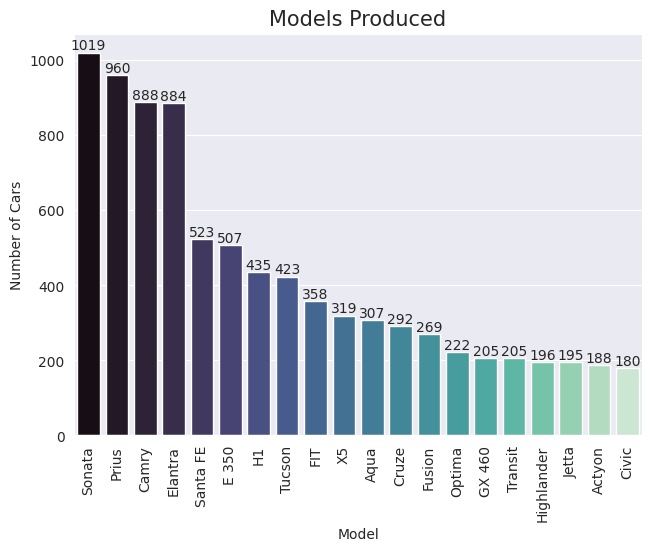

In [69]:
plt.title("Models Produced",fontsize=15)
plt.tight_layout(w_pad=15)
a=sns.barplot(x=Model.index,y=Model,palette="mako")
a.set_xticklabels(Model.index ,rotation=90)
a.set(xlabel='Model', ylabel='Number of Cars')
a.bar_label(a.containers[0],size = 10)
plt.show()

#### Category

In [70]:
df['category']

0             Jeep
1             Jeep
2        Hatchback
3             Jeep
4        Hatchback
           ...    
19232        Coupe
19233        Sedan
19234         Jeep
19235         Jeep
19236        Sedan
Name: category, Length: 18042, dtype: object

In [71]:
df['category'].unique()

array(['Jeep', 'Hatchback', 'Sedan', 'Microbus', 'Goods wagon',
       'Universal', 'Coupe', 'Minivan', 'Cabriolet', 'Limousine',
       'Pickup'], dtype=object)

In [72]:
Category=df['category'].value_counts()
Category

category
Sedan          8286
Jeep           5096
Hatchback      2558
Minivan         614
Coupe           518
Universal       361
Microbus        292
Goods wagon     227
Pickup           51
Cabriolet        33
Limousine         6
Name: count, dtype: int64

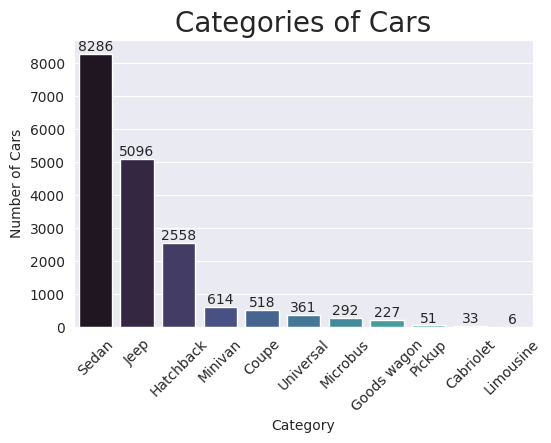

In [73]:
plt.title("Categories of Cars",fontsize=20)
plt.tight_layout(pad=5)
ax=sns.barplot(x=Category.index,y=Category,palette='mako')
ax.set_xticklabels(Category.index,rotation=45)
ax.set(xlabel='Category', ylabel='Number of Cars')
ax.bar_label(ax.containers[0])
plt.show()

#### Leather interior

In [74]:
df['leather_interior'].value_counts()

leather_interior
Yes    13090
No      4952
Name: count, dtype: int64

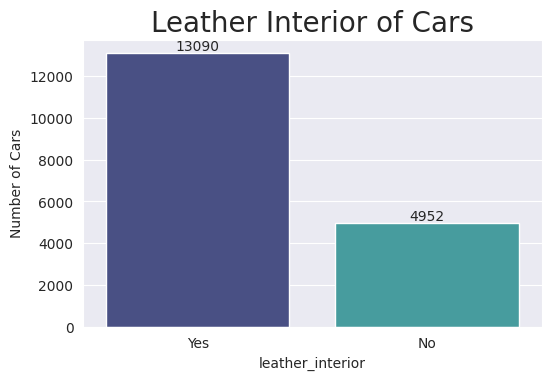

In [75]:
plt.title("Leather Interior of Cars",fontsize=20)
plt.tight_layout(pad=5)
ax=sns.countplot(data=df,x='leather_interior',palette='mako')
ax.set(ylabel='Number of Cars')
ax.bar_label(ax.containers[0])
plt.show()

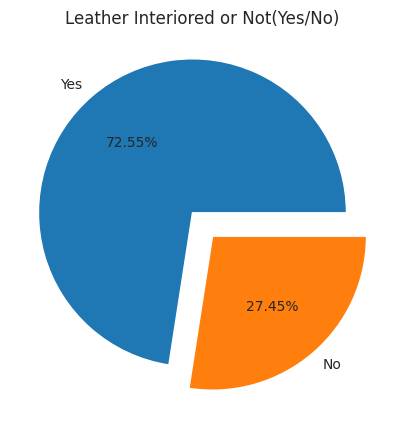

In [76]:
leather_Interior = ['Yes','No']
plt.figure(figsize=(6,5))
plt.title('Leather Interiored or Not(Yes/No)')
plt.pie(df['leather_interior'].value_counts(),autopct='%1.2f%%',labels = leather_Interior,explode=(0.1,0.1));
plt.show()

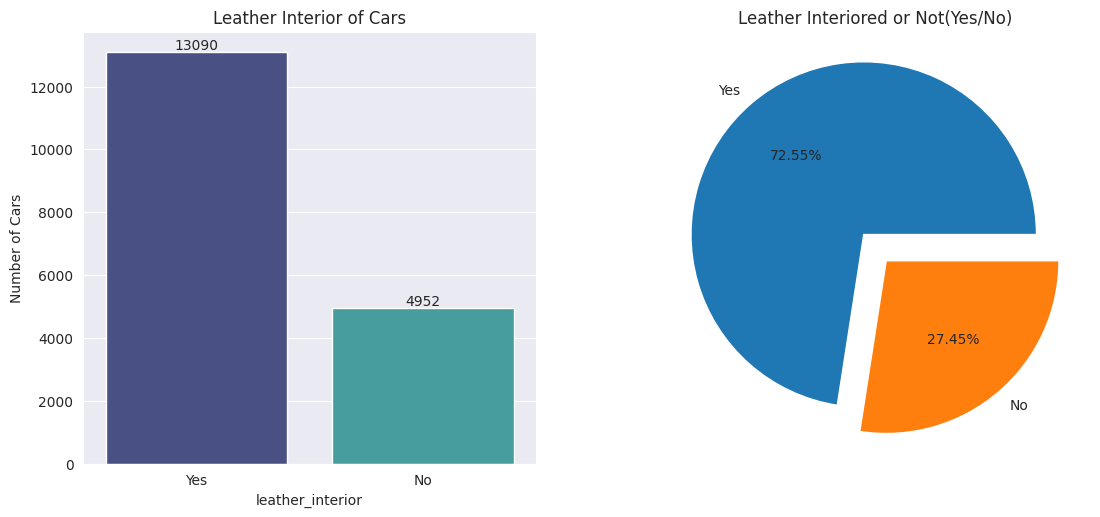

In [77]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.tight_layout(pad=5)
ax=sns.countplot(data=df,x='leather_interior',palette='mako',ax=axes[0])
ax.set(ylabel='Number of Cars')
ax.bar_label(ax.containers[0])
ax.title.set_text('Leather Interior of Cars')

leather_Interior = ['Yes','No']
plt.title('Leather Interiored or Not(Yes/No)')
axes[1].pie(df['leather_interior'].value_counts(),autopct='%1.2f%%',labels = leather_Interior,explode=(0.1,0.1));
plt.show()

#### Fuel Type

In [78]:
fuel_type= df['fuel_type'].value_counts()
fuel_type

fuel_type
Petrol            9528
Diesel            3894
Hybrid            3202
LPG                868
CNG                464
Plug-in Hybrid      85
Hydrogen             1
Name: count, dtype: int64

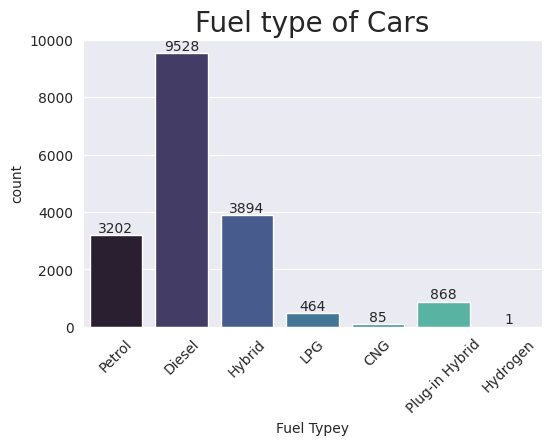

In [79]:
plt.title("Fuel type of Cars",fontsize=20)
plt.tight_layout(pad=5)
ax=sns.countplot(data=df,x='fuel_type',palette='mako')
ax.set(xlabel="Fuel Typey",label='Number of Cars')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(fuel_type.index,rotation=45)
plt.show()

In [80]:
df['drive_wheels'].value_counts()

drive_wheels
Front    12162
4x4       3679
Rear      2201
Name: count, dtype: int64

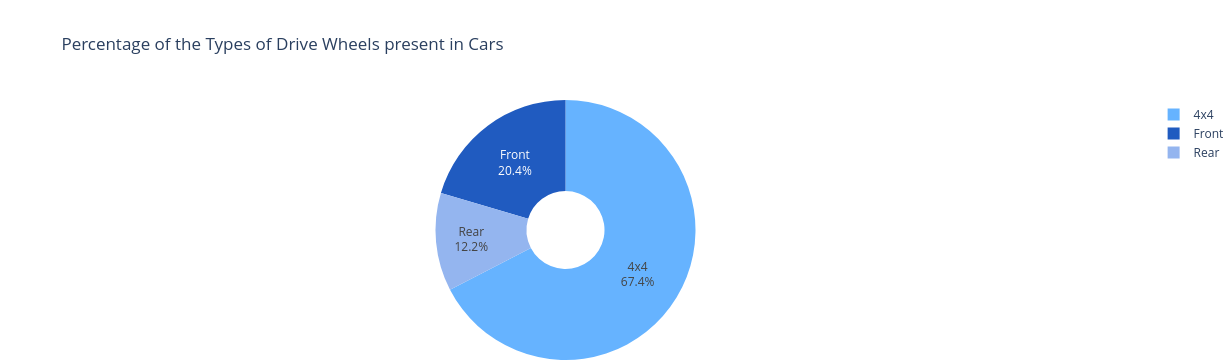

In [81]:
labels = df['drive_wheels'].unique().tolist()
sizes =  df['drive_wheels'].value_counts().tolist()
colors=['lightcyan','cyan','royalblue','darkblue']
colors = ['#66b3ff','#205bc0','#94b5ef']

fig = px.pie(df, values=sizes, names=labels, title='Percentage of the Types of Drive Wheels present in Cars',
             color_discrete_sequence=colors ,
             hole=.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(margin=dict( b=0, l=0, r=0))

fig.show()

#### Doors

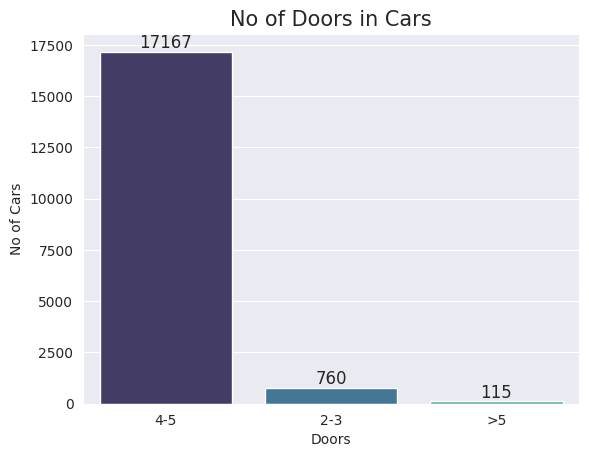

In [82]:
plt.title("No of Doors in Cars",fontsize=15)
doors = df['doors'].value_counts()
c1=sns.countplot(data=df,x='doors',palette="mako")
c1.set(xlabel='Doors',ylabel='No of Cars')
c1.bar_label(c1.containers[0],size = 12)
plt.show()

#### Wheels

In [83]:
df['wheel'].value_counts()

wheel
Left wheel          16729
Right-hand drive     1313
Name: count, dtype: int64

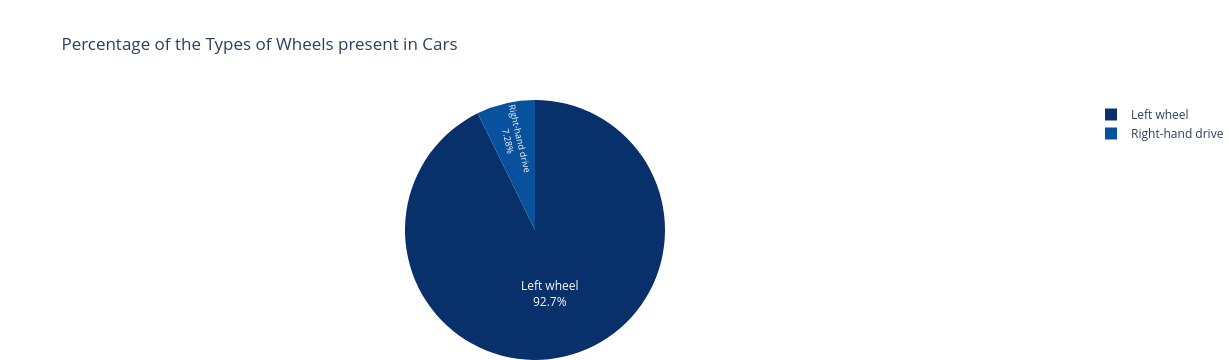

In [84]:
labels = df['wheel'].unique().tolist()
sizes =  df['wheel'].value_counts().tolist()
fig = px.pie(df, values=sizes, names=labels, title='Percentage of the Types of Wheels present in Cars',
color_discrete_sequence=px.colors.sequential.Blues_r)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(margin=dict( b=0, l=0, r=0))
fig.show()

#### Gear box type

In [85]:
df['gear_box_type'].value_counts()

gear_box_type
Automatic    12522
Tiptronic     3004
Manual        1815
Variator       701
Name: count, dtype: int64

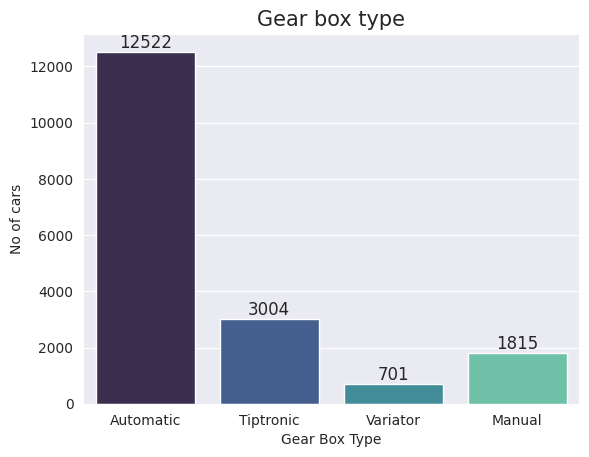

In [86]:
plt.title("Gear box type",fontsize=15)
c1=sns.countplot(x=df['gear_box_type'],palette="mako")
c1.bar_label(c1.containers[0],size = 12)
c1.set(xlabel="Gear Box Type",ylabel="No of cars")
plt.show()

* Most of the models have a Automatic kind of gear box.

## Multivariate Analysis

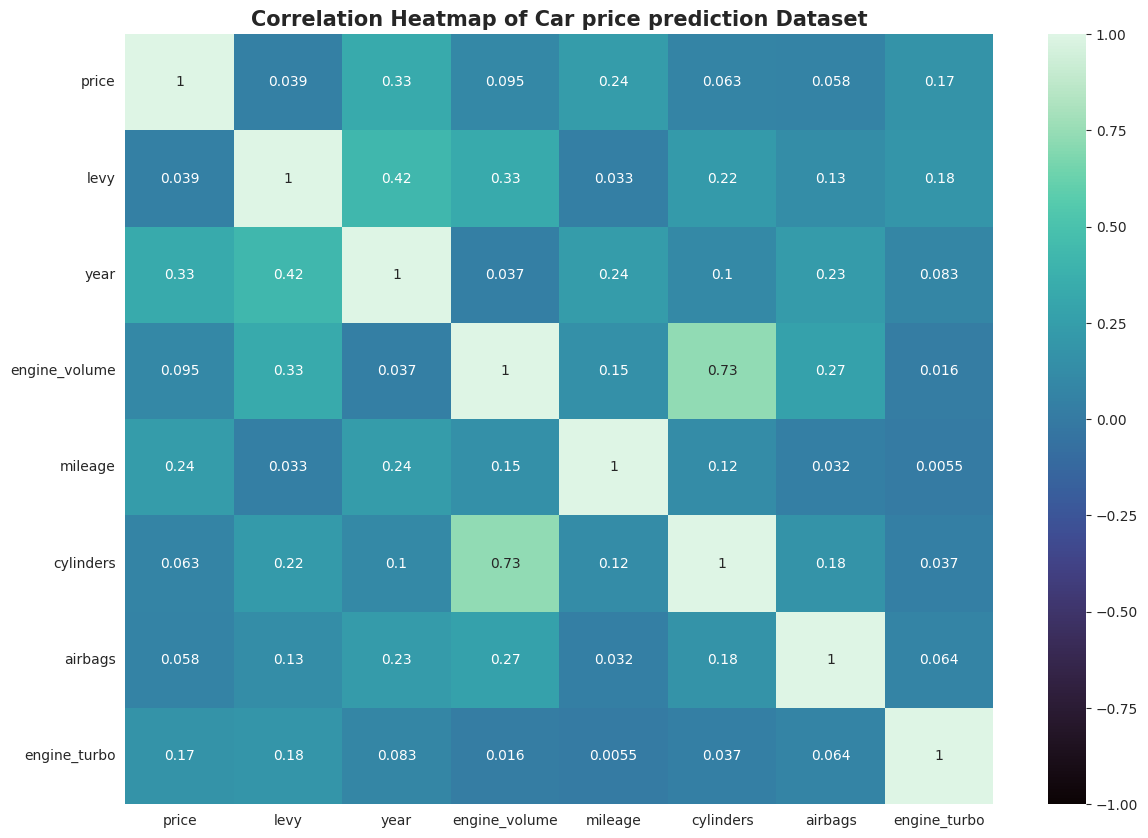

In [87]:
plt.figure(figsize=(14,10))
plot = sns.heatmap(abs(df.select_dtypes('number').corr()), annot=True, cmap='mako',vmin=-1)
plt.title('Correlation Heatmap of Car price prediction Dataset', weight='bold',fontsize=15)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center')
plot.set_yticklabels(plot.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

* There is no strong correlation among the variables .

In [88]:
df[['price','cylinders']].corr()

price  cylinders
price      1.000      0.063
cylinders  0.063      1.000

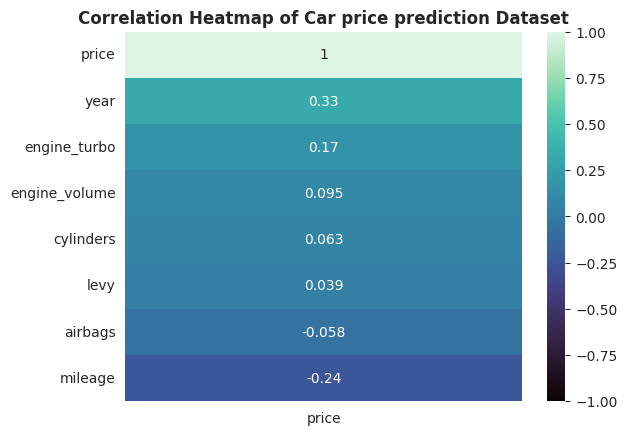

In [89]:
Target_corr  = df.select_dtypes('number').corr().loc[:, 'price'].to_frame().sort_values(by = 'price' , ascending=False)
plot = sns.heatmap(Target_corr, annot=True, cmap='mako', vmin = -1)
plt.title('Correlation Heatmap of Car price prediction Dataset', weight='bold')
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center')
plot.set_yticklabels(plot.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

In [90]:
df.groupby('manufacturer')['mileage'].max().sort_values(ascending=False)

manufacturer
LEXUS           362717.500
LINCOLN         362717.500
LAND ROVER      362717.500
MERCEDES-BENZ   362717.500
MITSUBISHI      362717.500
                   ...    
LANCIA           57000.000
BENTLEY          55500.000
MASERATI         50314.000
HAVAL            28000.000
LAMBORGHINI       2531.000
Name: mileage, Length: 64, dtype: float64

In [91]:
df.groupby('model')['mileage'].max().sort_values(ascending=False)

model
Astra        362717.500
Fusion       362717.500
Skyline      362717.500
525          362717.500
528          362717.500
                ...    
C 180 2.0         0.000
Lancer GTS        0.000
Jimny GLX         0.000
Impreza G4        0.000
Astra gi          0.000
Name: mileage, Length: 1575, dtype: float64

### Year wise variety of Cars:

In [92]:
df_wise_year = df.groupby(by= ['year'], as_index=False).count().sort_values(by='year', ascending=False)[['year','price']]
df_wise_year = df_wise_year.rename(columns={'price': 'count'})
df_wise_year['prd_yr_per'] = round(df_wise_year['count']/sum(df_wise_year['count'])*100,2)
df_wise_year

year  count  prd_yr_per
51  2020     46       0.250
50  2019    274       1.520
49  2018    479       2.650
48  2017    903       5.000
47  2016   1428       7.910
46  2015   1495       8.290
45  2014   1990      11.030
44  2013   1826      10.120
43  2012   2012      11.150
42  2011   1497       8.300
41  2010   1403       7.780
40  2009    565       3.130
39  2008    648       3.590
38  2007    428       2.370
37  2006    286       1.590
36  2005    355       1.970
35  2004    335       1.860
34  2003    332       1.840
33  2002    270       1.500
32  2001    248       1.370
31  2000    271       1.500
30  1999    204       1.130
29  1998    203       1.130
28  1997    150       0.830
27  1996    108       0.600
26  1995    101       0.560
25  1994     41       0.230
24  1993     22       0.120
23  1992     30       0.170
22  1991     10       0.060
21  1990     18       0.100
20  1989      6       0.030
19  1988     12       0.070
18  1987      5       0.030
17  1986      6       0.030
16  1985      5       0.030
15  1984      5       0.030
14  1983      3       0.020
13  1982      1       0.010
12  1981      1       0.010
11  1980      2       0.010
10  1978      2       0.010
9   1977      2       0.010
8   1976      1       0.010
7   1974      1       0.010
6   1973      1       0.010
5   1968      1       0.010
4   1965      2       0.010
3   1964      2       0.010
2   1957      1       0.010
1   1953      4       0.020
0   1943      1       0.010

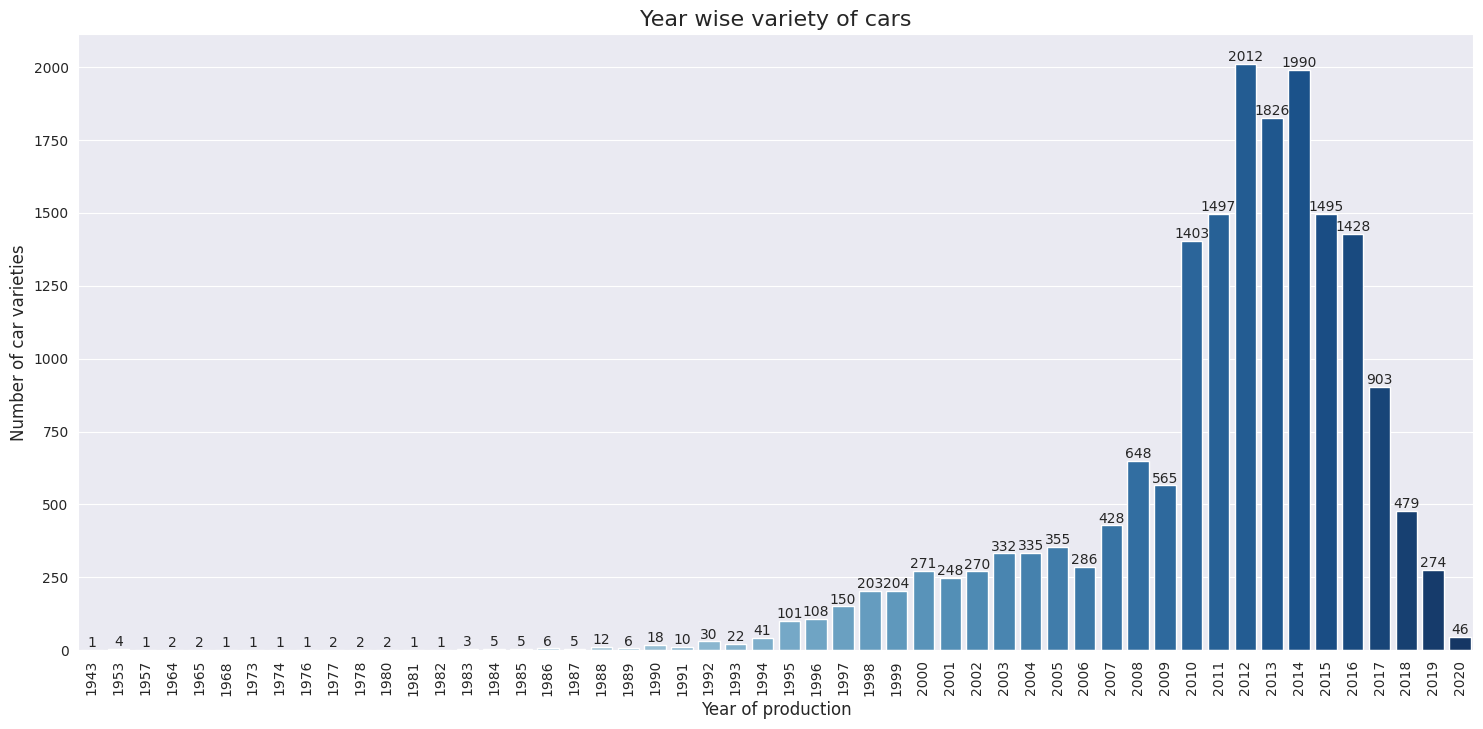

In [93]:
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'year', y = 'count',  data = df_wise_year,palette="Blues")
plt.title('Year wise variety of cars', fontsize=16)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, horizontalalignment='center')
plot.bar_label(container=plot.containers[0])
plt.xlabel('Year of production', fontsize=12)
plt.ylabel('Number of car varieties', fontsize=12)

plt.show()

* The quantity of car variants each year gradualy increases upto 2015 after which we get to witness a decline.

### Manufacturer's variety of cars:

In [94]:
df_wise_manu = df.groupby(by= ['manufacturer'], as_index=False).count().sort_values(by='price', ascending=False)[['manufacturer','price']]
df_wise_manu = df_wise_manu.rename(columns={'price': 'count'})
df_wise_manu

manufacturer  count
23        HYUNDAI   3645
57         TOYOTA   3359
36  MERCEDES-BENZ   1938
16           FORD   1024
8       CHEVROLET   1019
..            ...    ...
30         LANCIA      1
29    LAMBORGHINI      1
2    ASTON MARTIN      1
49         SATURN      1
19      GREATWALL      1

[64 rows x 2 columns]

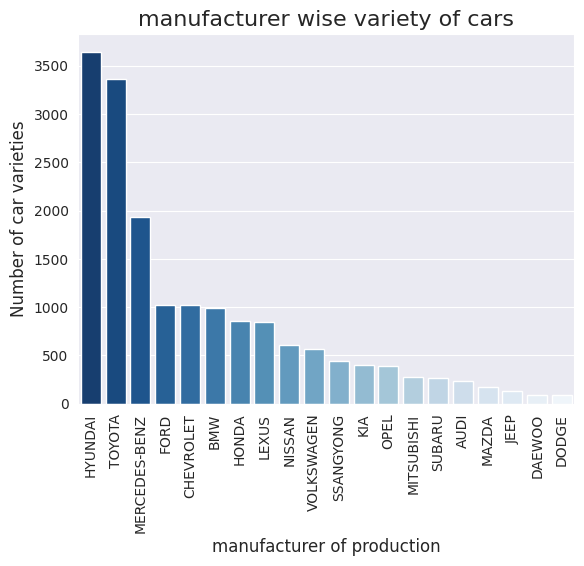

In [95]:
plot = sns.barplot(x = 'manufacturer', y = 'count',  data = df_wise_manu.head(20),palette="Blues_r")
plt.title('manufacturer wise variety of cars', fontsize=16)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.xlabel('manufacturer of production', fontsize=12)
plt.ylabel('Number of car varieties', fontsize=12)
plt.show()

* Hyundai , Toyota and Mercedes-Benz have the highest variants of cars.

### Mean Price wise analysis of each feature

In [96]:
lcv=df.select_dtypes('object')
for column in lcv:
    print(column)
    print(df[['price', column]].groupby(by= [column], as_index=False).agg('mean').sort_values(by='price', ascending=False))

manufacturer
    manufacturer     price
2   ASTON MARTIN 47356.000
56         TESLA 47356.000
4        BENTLEY 47356.000
29   LAMBORGHINI 47356.000
14       FERRARI 39672.000
..           ...       ...
51          SEAT  4829.500
59           VAZ  4659.894
40      MOSKVICH  4609.000
62           ZAZ  3822.500
47         ROVER  2433.333

[64 rows x 2 columns]
model
               model     price
769   GL 350 Bluetec 47356.000
1363    Sprinter 516 47356.000
182              635 47356.000
183              640 47356.000
184   640 GRAN-COUPE 47356.000
...              ...       ...
165            535 M   350.000
1306    Serena Serea   348.000
107              401   314.000
1406     Trailblazer   300.000
1272      S 550 LONG   300.000

[1575 rows x 2 columns]
category
       category     price
8        Pickup 23435.922
0     Cabriolet 22453.576
10    Universal 22270.216
4          Jeep 22103.824
5     Limousine 21012.000
7       Minivan 20747.383
6      Microbus 18243.914
1         Coupe 1811

In [97]:
lcv.drop(columns=['manufacturer','model'],inplace=True)

In [98]:
def annot_percent(axes):
    for p in plot.patches:
        total = sum(p.get_height() for p in plot.patches)/100
        percent = round((p.get_height()/total),2)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()*1.015
        plot.annotate(f'{percent}%', (x, y), ha='center', va='bottom')

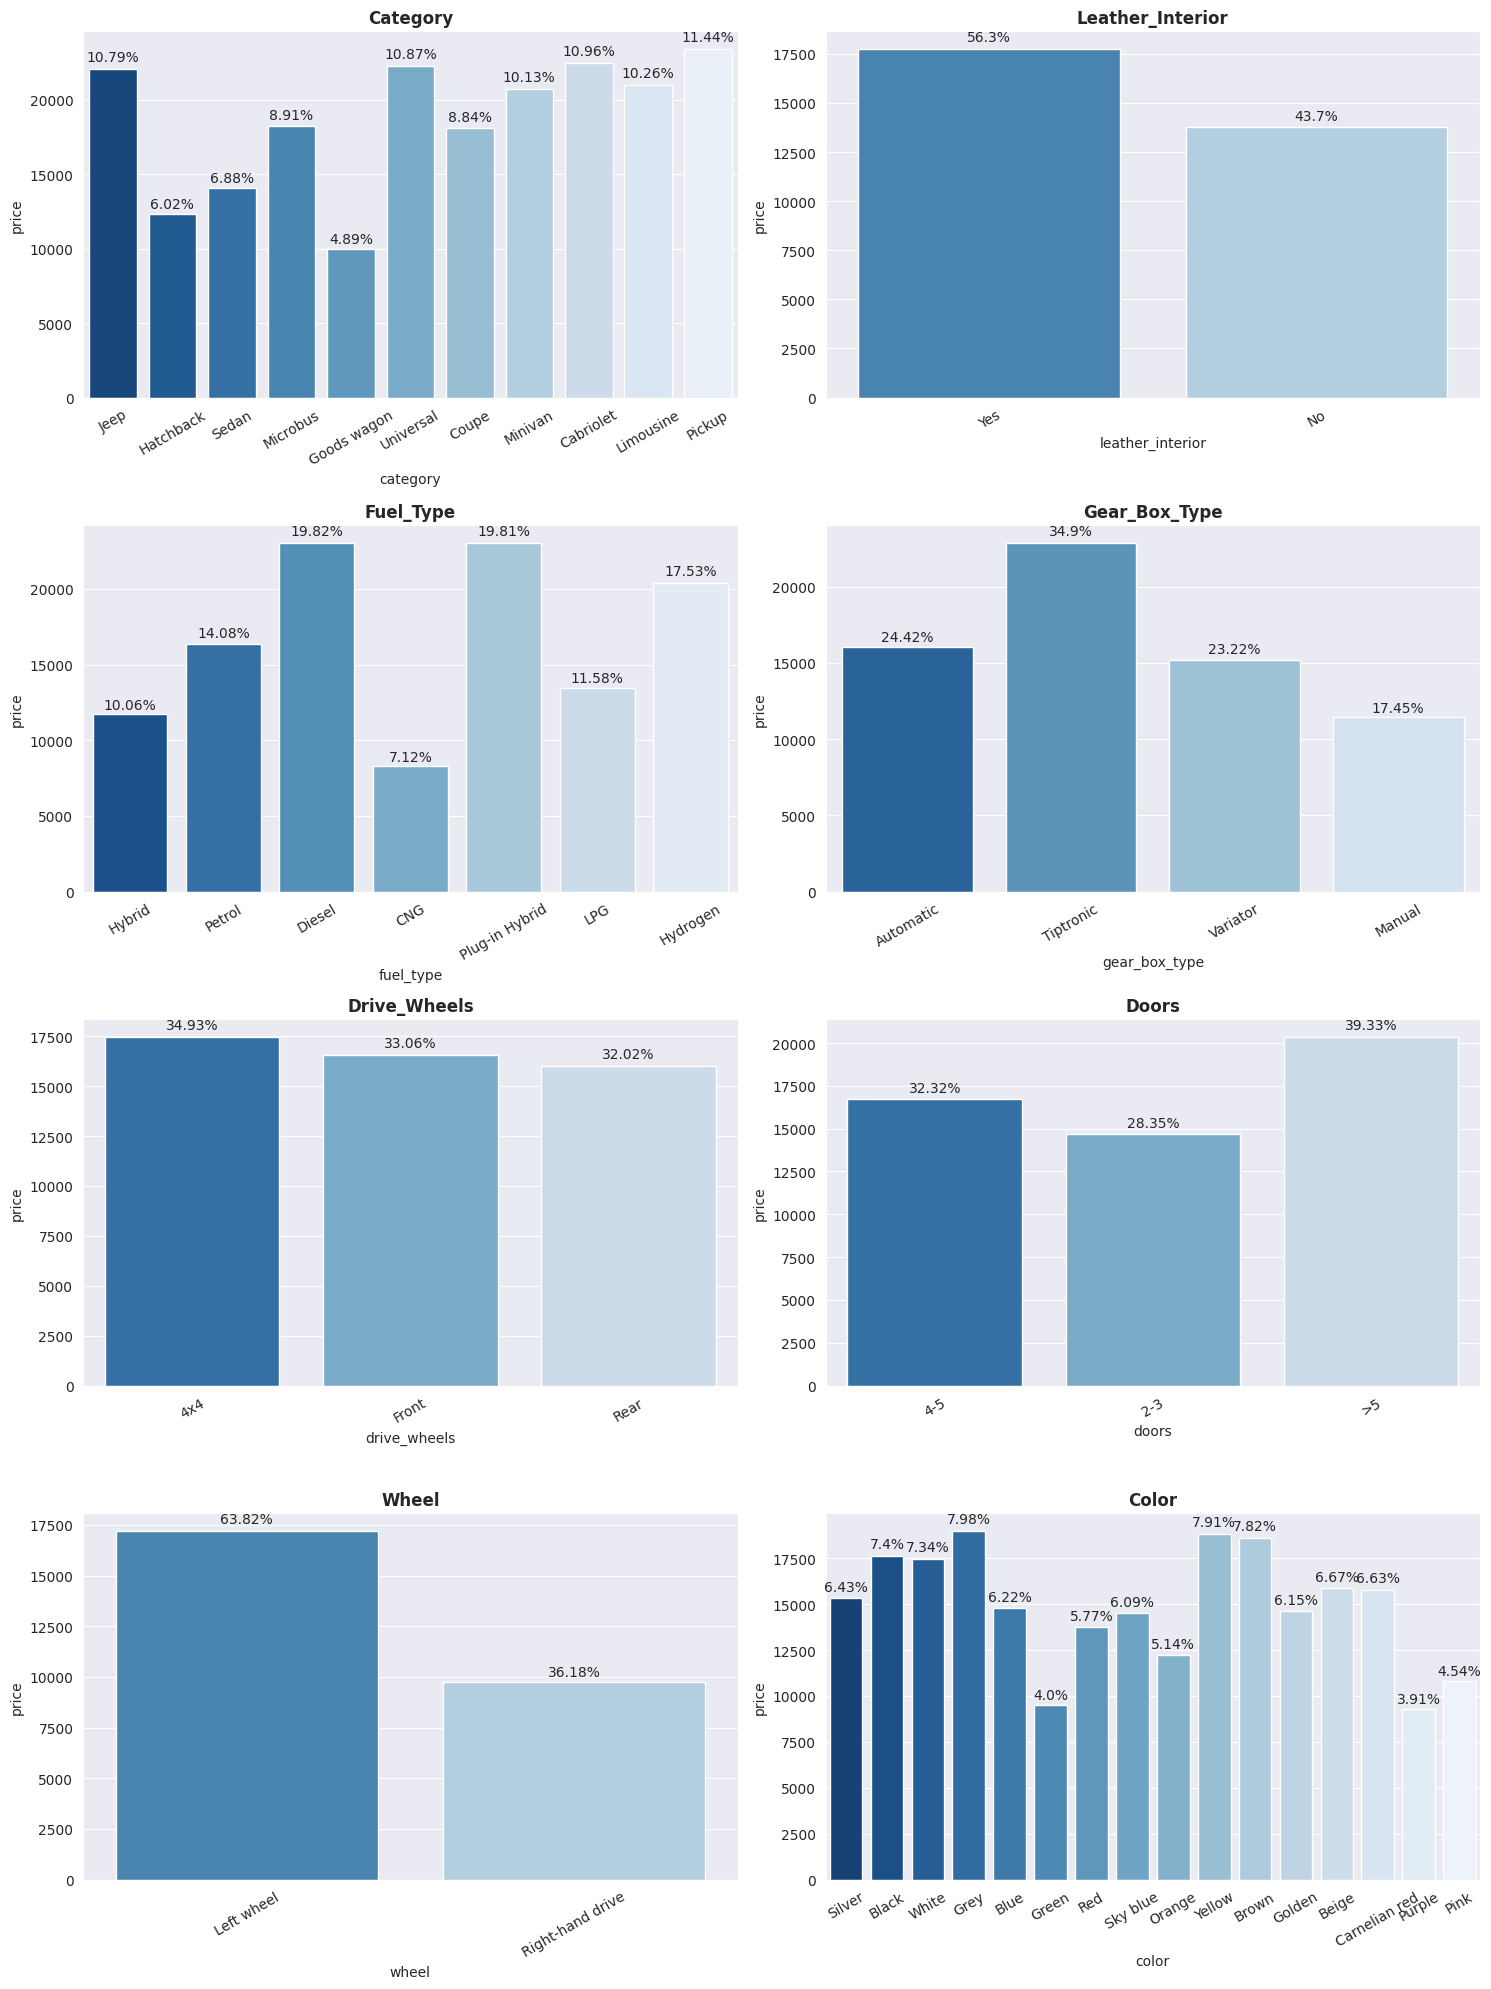

In [99]:
plt.figure(figsize=(15,20))
for n,column in  enumerate(lcv):
    plot=plt.subplot(4,2,n+1)
    c1=sns.barplot(x =df[column], y= df['price'],palette="Blues_r",errorbar=None)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=30, horizontalalignment='center')
    plt.title(f'{column.title()}',weight='bold')
    plt.tight_layout()
    # Add annotations to the bar plot
    annot_percent(plot)

* The average price of Diesel car is maximum and CNG is the minimum.
* The average price of 4x4,Front and Rear drives wheels are almost similar.
* 2-3 Doors has the highest average maximum price.
* Left wheel drive has the maximum average price.

In [100]:
df_price_wise_manu=df[['price', 'manufacturer']].groupby(by= 'manufacturer', as_index=False).agg('mean').sort_values(by='price', ascending=False)
df_price_wise_manu

manufacturer     price
2   ASTON MARTIN 47356.000
56         TESLA 47356.000
4        BENTLEY 47356.000
29   LAMBORGHINI 47356.000
14       FERRARI 39672.000
..           ...       ...
51          SEAT  4829.500
59           VAZ  4659.894
40      MOSKVICH  4609.000
62           ZAZ  3822.500
47         ROVER  2433.333

[64 rows x 2 columns]

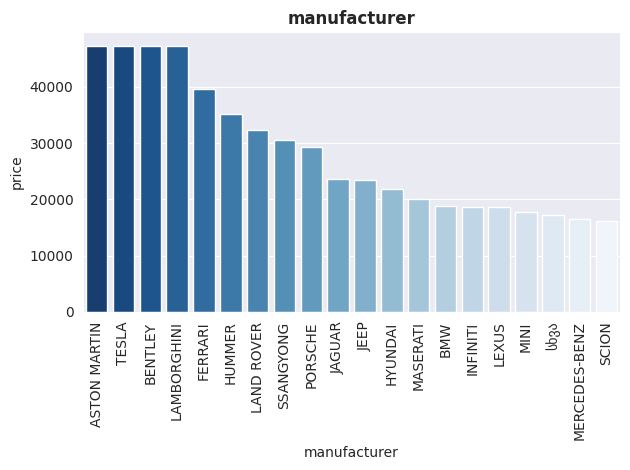

In [101]:
c1=sns.barplot(data=df_price_wise_manu.head(20),x ='manufacturer', y= 'price',palette="Blues_r")
c1.set_xticklabels(c1.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.title('manufacturer',weight='bold')
plt.tight_layout()

In [102]:
df_price_wise_model=df[['price', 'model']].groupby(by= 'model', as_index=False).agg('mean').sort_values(by='price', ascending=False)
df_price_wise_model

model     price
769   GL 350 Bluetec 47356.000
1363    Sprinter 516 47356.000
182              635 47356.000
183              640 47356.000
184   640 GRAN-COUPE 47356.000
...              ...       ...
165            535 M   350.000
1306    Serena Serea   348.000
107              401   314.000
1406     Trailblazer   300.000
1272      S 550 LONG   300.000

[1575 rows x 2 columns]

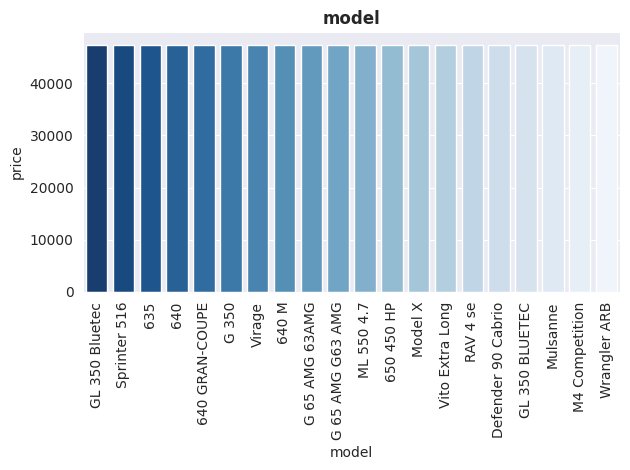

In [103]:
c1=sns.barplot(data=df_price_wise_model.head(20),x ='model', y= 'price',palette="Blues_r")
c1.set_xticklabels(c1.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.title('model',weight='bold')
plt.tight_layout()

### Average Production Price for each year:

In [104]:
price_wise_years=df.groupby('year')['price'].agg('mean').sort_values(ascending=False).to_frame()
price_wise_years.head(10)

price
year          
1943 47356.000
1965 47356.000
2020 32886.478
1982 31361.000
2018 27493.933
2016 26031.043
2017 25071.721
2019 22270.197
2015 19327.765
2014 17742.995

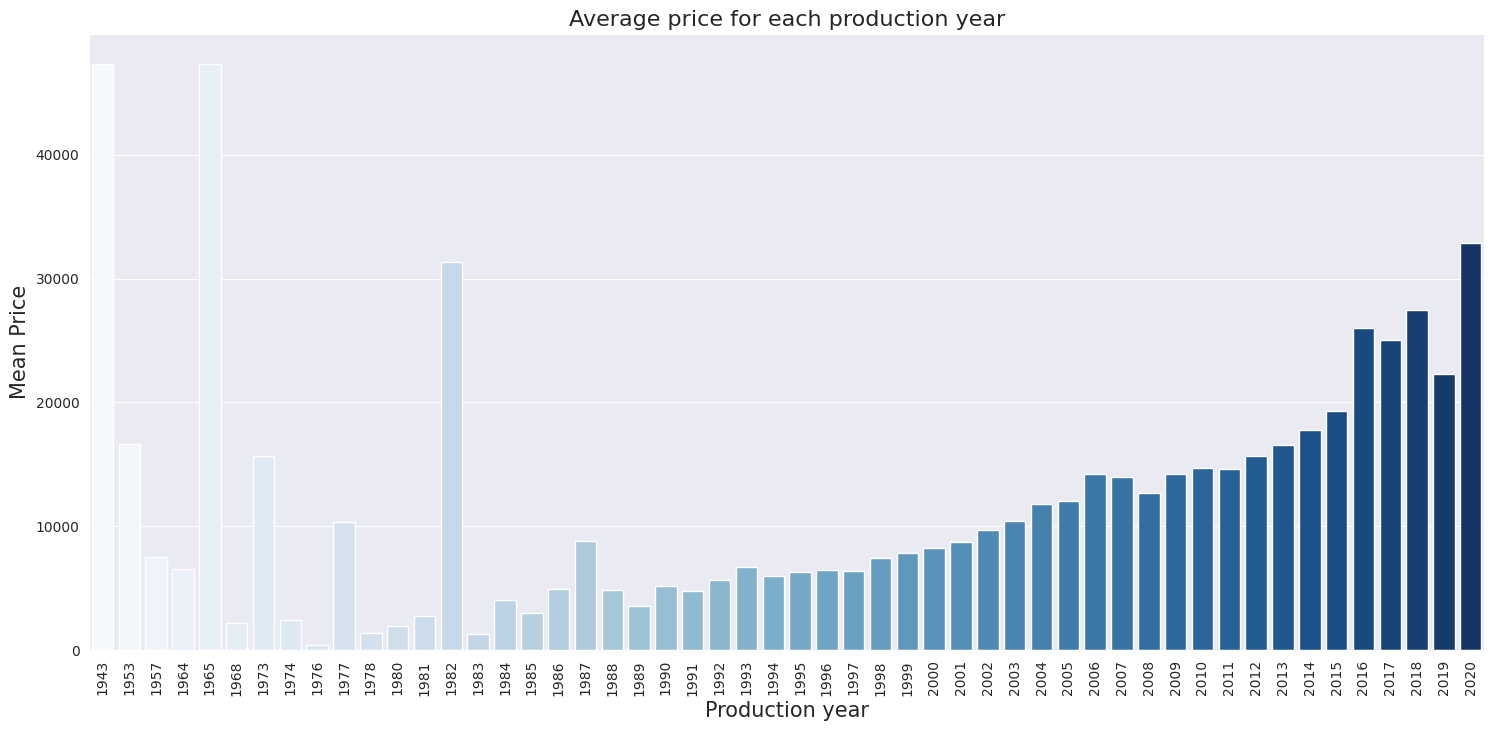

In [105]:
plt.figure(figsize=(18,8))
plot = sns.barplot(x="year", y="price", data=df,palette="Blues",errorbar=None)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.title('Average price for each production year', fontsize=16)
plt.xlabel('Production year', fontsize=15)
plt.ylabel('Mean Price', fontsize=15)
plt.show()

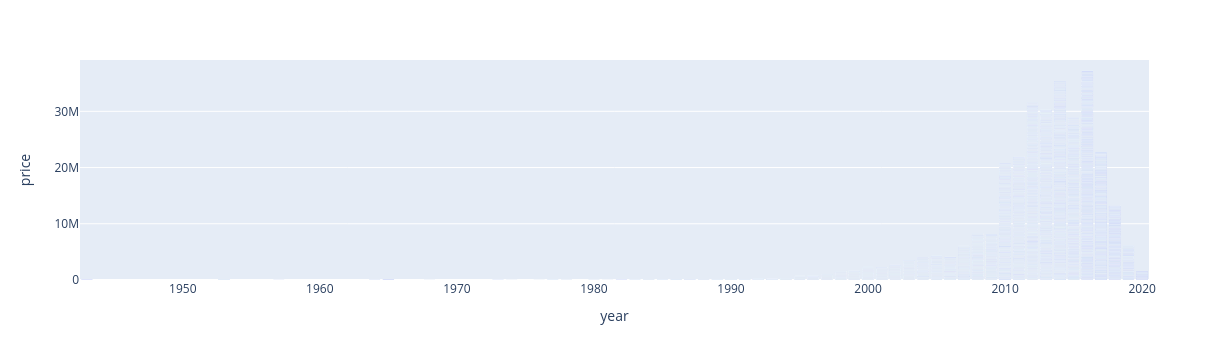

In [106]:
px.bar(data_frame=df,x='year',y='price')


*  From the given plot we can infer that there seems to be general increase in the average price of the car each year.







<Axes: xlabel='year', ylabel='price'>

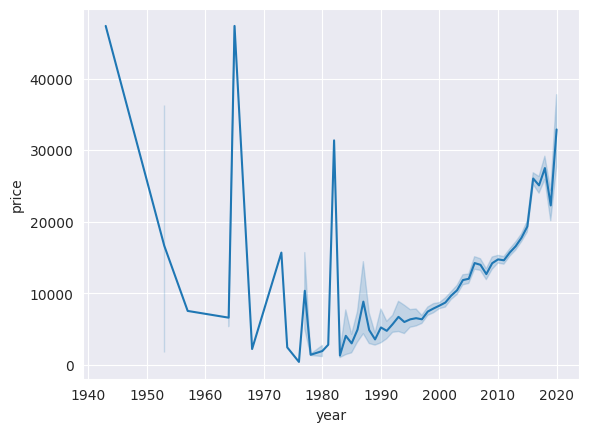

In [107]:
# px.line(data_frame=df,x='year',y='price')
sns.lineplot(data=df,x='year', y= 'price')


### Comparison of year wise mean price and individual features

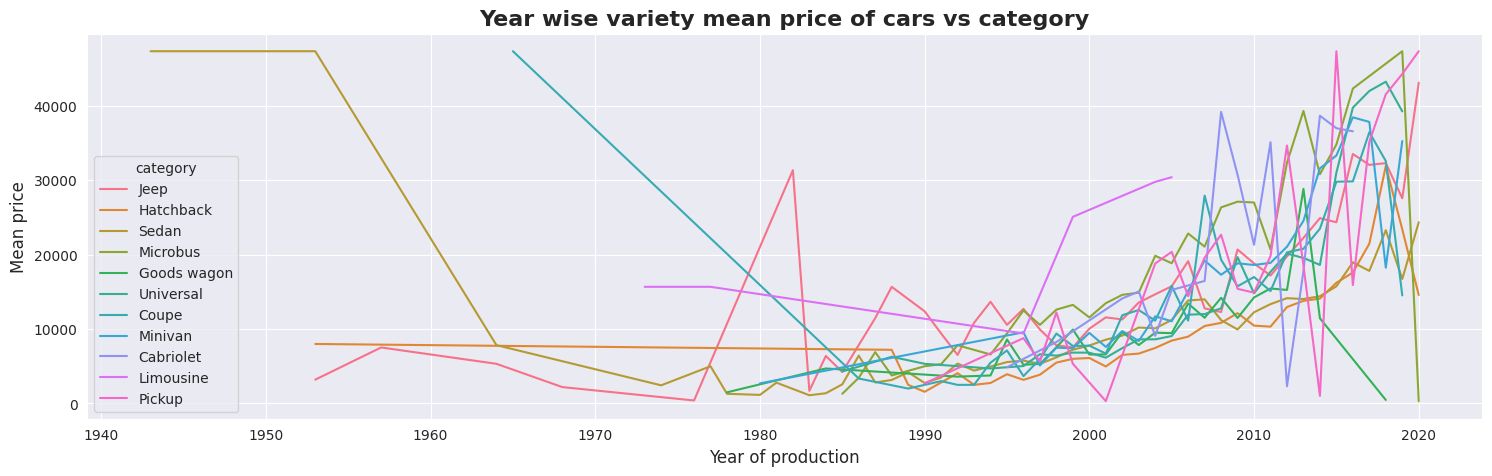

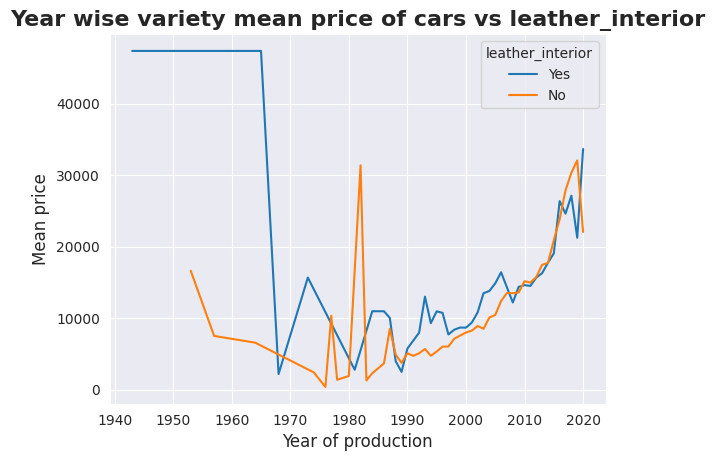

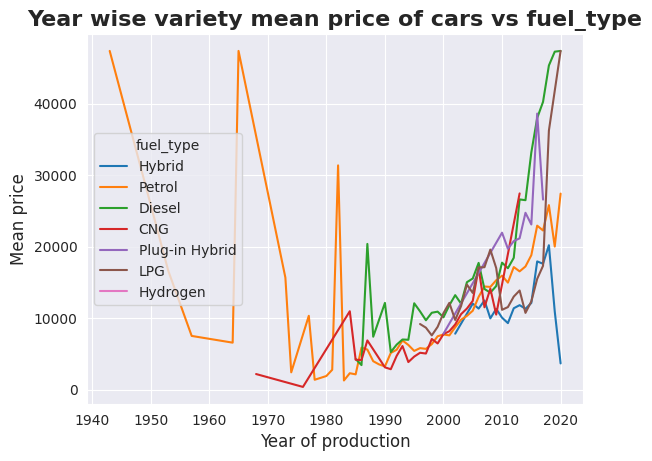

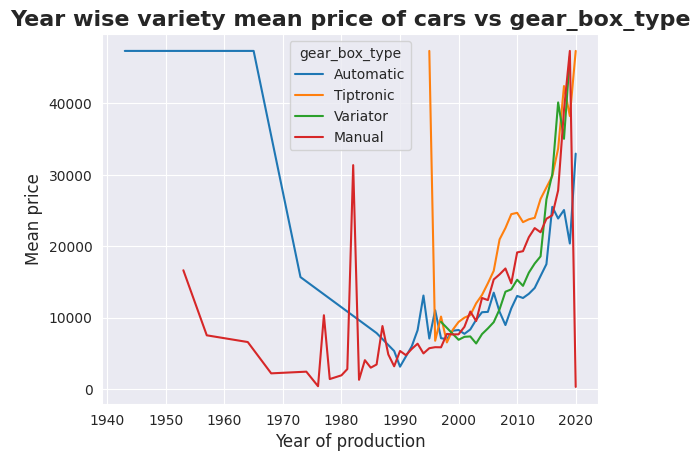

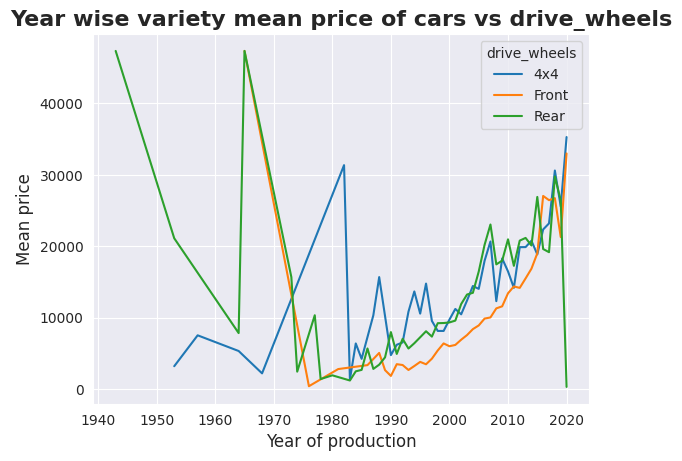

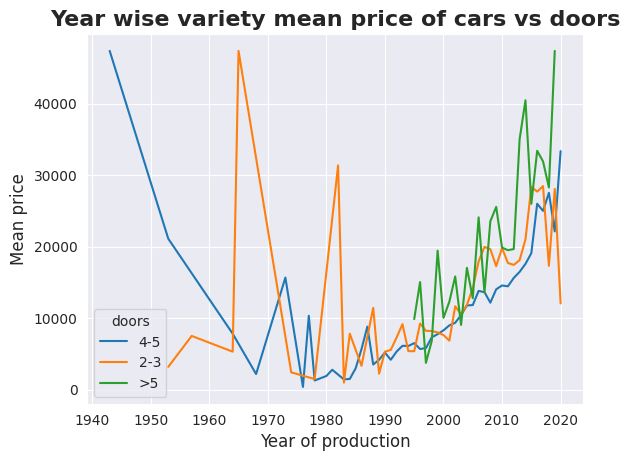

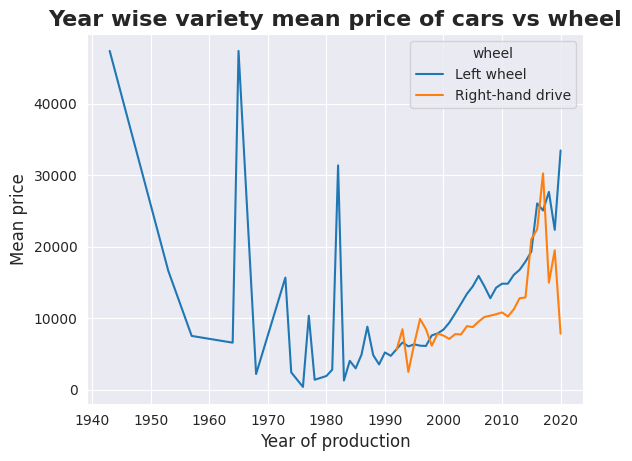

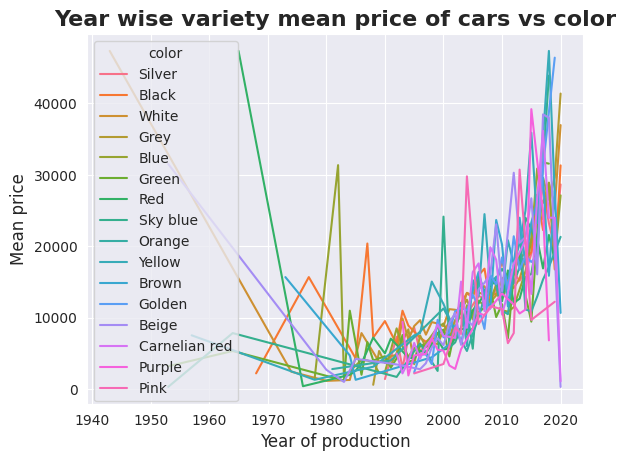

In [108]:
plt.figure(figsize=(18,5))
for n,column in  enumerate(lcv):
    sns.lineplot(data=df,x='year', y= 'price',hue=column,errorbar=None)
    plt.title(f'Year wise variety mean price of cars vs {column}', fontsize=16,weight='bold')
    plt.xlabel('Year of production', fontsize=12)
    plt.ylabel('Mean price', fontsize=12)    
    plt.show()

#### From the above plots we can infer that:

* The average price of tiptronic engines have risen due to a surge in demand over the last few years.

* Leather interior's average price is always high.
* There is also an increase in the average price of diesel engines.

In [109]:
df.columns

Index(['price', 'levy', 'manufacturer', 'model', 'year', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags', 'engine_turbo'],
      dtype='object')

In [110]:
df

price     levy   manufacturer    model  year   category   
0      13328 1399.000          LEXUS   RX 450  2010       Jeep  \
1      16621 1018.000      CHEVROLET  Equinox  2011       Jeep   
2       8467    0.000          HONDA      FIT  2006  Hatchback   
3       3607  862.000           FORD   Escape  2011       Jeep   
4      11726  446.000          HONDA      FIT  2014  Hatchback   
...      ...      ...            ...      ...   ...        ...   
19232   8467    0.000  MERCEDES-BENZ  CLK 200  1999      Coupe   
19233  15681  831.000        HYUNDAI   Sonata  2011      Sedan   
19234  26108  836.000        HYUNDAI   Tucson  2010       Jeep   
19235   5331 1288.000      CHEVROLET  Captiva  2007       Jeep   
19236    470  753.000        HYUNDAI   Sonata  2012      Sedan   

      leather_interior fuel_type  engine_volume    mileage  cylinders   
0                  Yes    Hybrid          3.500 186005.000      6.000  \
1                   No    Petrol          3.000 192000.000      6.000   
2                   No    Petrol          1.300 200000.000      4.000   
3                  Yes    Hybrid          2.500 168966.000      4.000   
4                  Yes    Petrol          1.300  91901.000      4.000   
...                ...       ...            ...        ...        ...   
19232              Yes       CNG          2.000 300000.000      4.000   
19233              Yes    Petrol          2.400 161600.000      4.000   
19234              Yes    Diesel          2.000 116365.000      4.000   
19235              Yes    Diesel          2.000  51258.000      4.000   
19236              Yes    Hybrid          2.400 186923.000      4.000   

      gear_box_type drive_wheels doors             wheel   color  airbags   
0         Automatic          4x4   4-5        Left wheel  Silver       12  \
1         Tiptronic          4x4   4-5        Left wheel   Black        8   
2          Variator        Front   4-5  Right-hand drive   Black        2   
3         Automatic          4x4   4-5        Left wheel   White        0   
4         Automatic        Front   4-5        Left wheel  Silver        4   
...             ...          ...   ...               ...     ...      ...   
19232        Manual         Rear   2-3        Left wheel  Silver        5   
19233     Tiptronic        Front   4-5        Left wheel     Red        8   
19234     Automatic        Front   4-5        Left wheel    Grey        4   
19235     Automatic        Front   4-5        Left wheel   Black        4   
19236     Automatic        Front   4-5        Left wheel   White       12   

       engine_turbo  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
19232             1  
19233             0  
19234             0  
19235             0  
19236             0  

[18042 rows x 18 columns]

## Feature extraction

In [111]:
df['age']=2023-df['year']
df['age']

0        13
1        12
2        17
3        12
4         9
         ..
19232    24
19233    12
19234    13
19235    16
19236    11
Name: age, Length: 18042, dtype: int64

In [112]:
df.drop('year',axis=1,inplace=True)

In [113]:
df.to_csv('data_set/car_price_cleaned.csv',index=False)

## Feature Encoding


In [123]:
df_encoding=df.copy(deep=True)

In [124]:
df_encoding.shape

(18042, 18)

In [125]:
df_encoding.drop(['color'],axis=1,inplace=True)
df_encoding.head(5)

price     levy manufacturer    model   category leather_interior fuel_type   
0  13328 1399.000        LEXUS   RX 450       Jeep              Yes    Hybrid  \
1  16621 1018.000    CHEVROLET  Equinox       Jeep               No    Petrol   
2   8467    0.000        HONDA      FIT  Hatchback               No    Petrol   
3   3607  862.000         FORD   Escape       Jeep              Yes    Hybrid   
4  11726  446.000        HONDA      FIT  Hatchback              Yes    Petrol   

   engine_volume    mileage  cylinders gear_box_type drive_wheels doors   
0          3.500 186005.000      6.000     Automatic          4x4   4-5  \
1          3.000 192000.000      6.000     Tiptronic          4x4   4-5   
2          1.300 200000.000      4.000      Variator        Front   4-5   
3          2.500 168966.000      4.000     Automatic          4x4   4-5   
4          1.300  91901.000      4.000     Automatic        Front   4-5   

              wheel  airbags  engine_turbo  age  
0        Left wheel       12             0   13  
1        Left wheel        8             0   12  
2  Right-hand drive        2             0   17  
3        Left wheel        0             0   12  
4        Left wheel        4             0    9

In [126]:
X=df_encoding.drop('price',axis=1)
y = df_encoding['price']
X.shape,y.shape

((18042, 16), (18042,))

In [127]:
X.head()

levy manufacturer    model   category leather_interior fuel_type   
0 1399.000        LEXUS   RX 450       Jeep              Yes    Hybrid  \
1 1018.000    CHEVROLET  Equinox       Jeep               No    Petrol   
2    0.000        HONDA      FIT  Hatchback               No    Petrol   
3  862.000         FORD   Escape       Jeep              Yes    Hybrid   
4  446.000        HONDA      FIT  Hatchback              Yes    Petrol   

   engine_volume    mileage  cylinders gear_box_type drive_wheels doors   
0          3.500 186005.000      6.000     Automatic          4x4   4-5  \
1          3.000 192000.000      6.000     Tiptronic          4x4   4-5   
2          1.300 200000.000      4.000      Variator        Front   4-5   
3          2.500 168966.000      4.000     Automatic          4x4   4-5   
4          1.300  91901.000      4.000     Automatic        Front   4-5   

              wheel  airbags  engine_turbo  age  
0        Left wheel       12             0   13  
1        Left wheel        8             0   12  
2  Right-hand drive        2             0   17  
3        Left wheel        0             0   12  
4        Left wheel        4             0    9

In [128]:
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size= 0.25 ,random_state=42)

In [129]:
cat_cols=X_train.select_dtypes(include='object').columns.tolist()
num_cols=X_train.select_dtypes(include='number').columns.tolist()
cat_cols

['manufacturer',
 'model',
 'category',
 'leather_interior',
 'fuel_type',
 'gear_box_type',
 'drive_wheels',
 'doors',
 'wheel']

In [130]:
num_cols

['levy',
 'engine_volume',
 'mileage',
 'cylinders',
 'airbags',
 'engine_turbo',
 'age']

In [131]:
enc = ce.OrdinalEncoder(cols=cat_cols,drop_invariant=False,return_df=True)

In [132]:
X_train[cat_cols] = enc.fit_transform(X_train[cat_cols])
X_test[cat_cols] = enc.transform(X_test[cat_cols])

In [133]:
X_train.head()

levy  manufacturer  model  category  leather_interior  fuel_type   
18041   0.000             1      1         1                 1          1  \
10086 308.000             2      2         1                 2          2   
1891  934.000             2      3         2                 1          1   
15768 531.000             3      4         2                 2          1   
18257 915.000             4      5         1                 2          1   

       engine_volume    mileage  cylinders  gear_box_type  drive_wheels   
18041          1.300 190000.000      4.000              1             1  \
10086          1.500 178442.000      4.000              2             1   
1891           2.500 110734.000      4.000              2             1   
15768          1.600 165000.000      4.000              2             1   
18257          3.000 140507.000      6.000              2             2   

       doors  wheel  airbags  engine_turbo  age  
18041      1      1        4             0   20  
10086      1      2        4             0    8  
1891       1      2       12             0    8  
15768      1      2        4             0   11  
18257      1      2        0             0    9

In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13531 entries, 18041 to 16826
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   levy              13531 non-null  float64
 1   manufacturer      13531 non-null  int64  
 2   model             13531 non-null  int64  
 3   category          13531 non-null  int64  
 4   leather_interior  13531 non-null  int64  
 5   fuel_type         13531 non-null  int64  
 6   engine_volume     13531 non-null  float64
 7   mileage           13531 non-null  float64
 8   cylinders         13531 non-null  float64
 9   gear_box_type     13531 non-null  int64  
 10  drive_wheels      13531 non-null  int64  
 11  doors             13531 non-null  int64  
 12  wheel             13531 non-null  int64  
 13  airbags           13531 non-null  int64  
 14  engine_turbo      13531 non-null  int64  
 15  age               13531 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 1.

## ML Model

### Scaler

In [135]:
scaler = PowerTransformer()

In [136]:
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

In [137]:
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [138]:
def cal_acc(model):
  y_pred=model.predict(X_test_scaled)
  mae = round(mean_absolute_error(y_test, y_pred), 3)
  mse = round(mean_squared_error(y_test, y_pred), 3)
  rmse = round(np.sqrt(mse), 3)
  r2_value = round(r2_score(y_test, y_pred), 3)
  print('Mean Absolute Error  of the model is : {}'.format(mae))
  print('Mean Squared Error of the model is : {}'.format(mse))
  print('Root Mean Squared Error of the model is : {}'.format(rmse))
  print('R-squared value of the model is : {}'.format(r2_value))
  data = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
  data.head()
  plt.figure(figsize=(12,8))
  custom_palette = ["#FF5A5F", "#7B113A"]
  sns.lineplot(data=data[:50],palette=custom_palette)
  plt.show()

### **Linear** *Regression*

In [139]:
lr_model  = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

Mean Absolute Error  of the model is : 8473.734
Mean Squared Error of the model is : 118576516.807
Root Mean Squared Error of the model is : 10889.284
R-squared value of the model is : 0.318


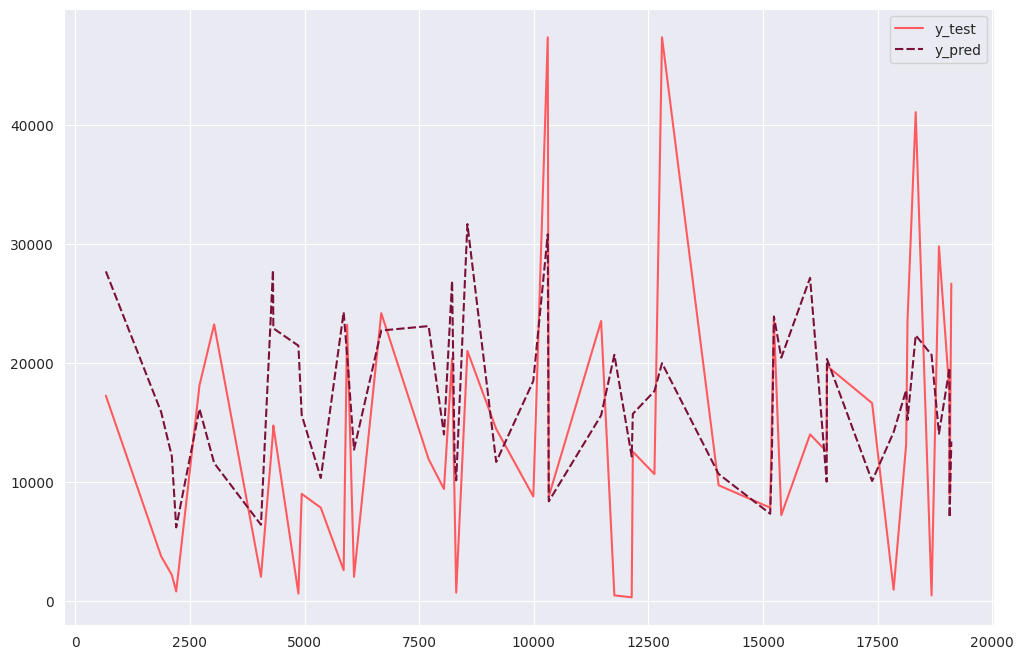

In [140]:
cal_acc(lr_model)

### KNeighborsRegressor

In [141]:
knn= KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=8)

Mean Absolute Error  of the model is : 4984.603
Mean Squared Error of the model is : 63228392.096
Root Mean Squared Error of the model is : 7951.628
R-squared value of the model is : 0.636


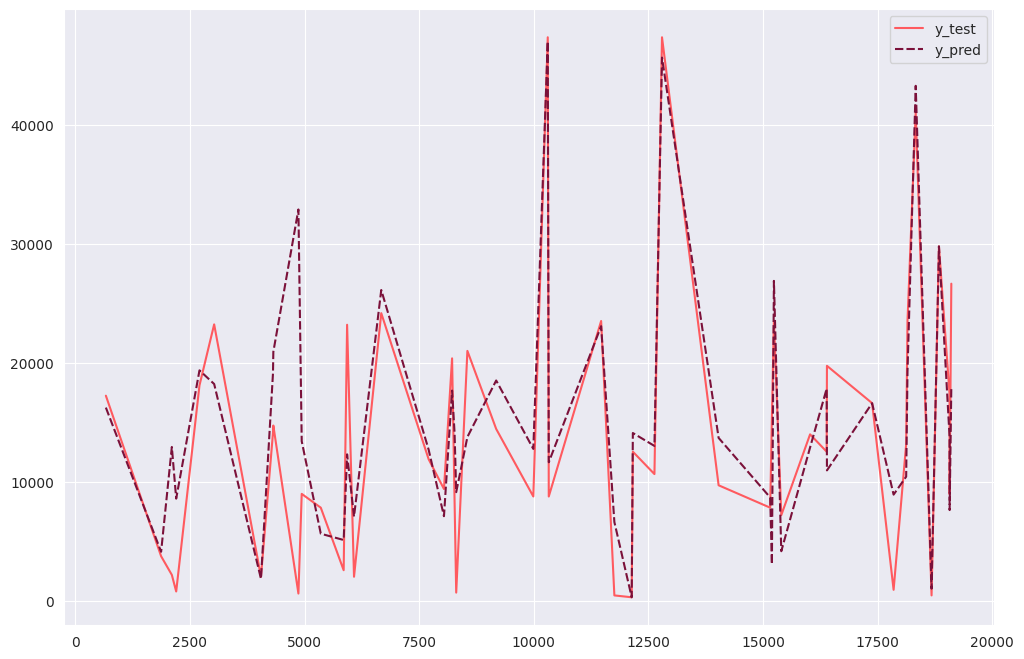

In [142]:
cal_acc(knn)

### GradientBoostingRegressor

In [143]:
gbr = GradientBoostingRegressor(n_estimators=380,learning_rate=0.4,random_state=1)
gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.4, n_estimators=380, random_state=1)

Mean Absolute Error  of the model is : 4295.936
Mean Squared Error of the model is : 41654459.272
Root Mean Squared Error of the model is : 6454.027
R-squared value of the model is : 0.76


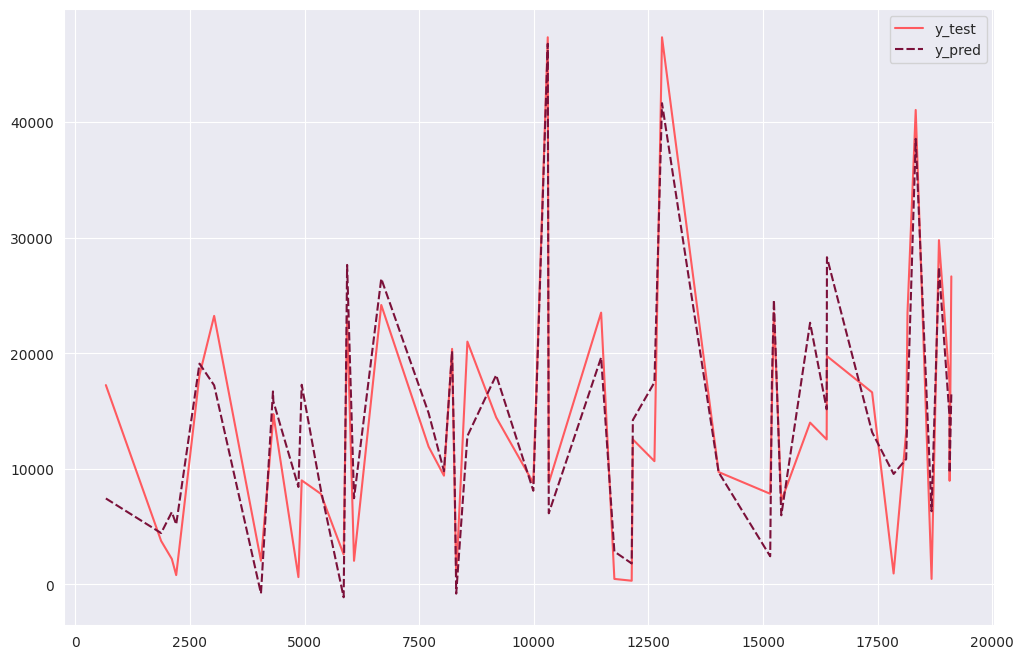

In [144]:
cal_acc(gbr)

### RandomForestRegressor



In [145]:
Rf = RandomForestRegressor(n_estimators=800, max_depth=20, max_features='log2', random_state=1)
Rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=800,
                      random_state=1)

Mean Absolute Error  of the model is : 3470.496
Mean Squared Error of the model is : 33062285.46
Root Mean Squared Error of the model is : 5749.981
R-squared value of the model is : 0.81


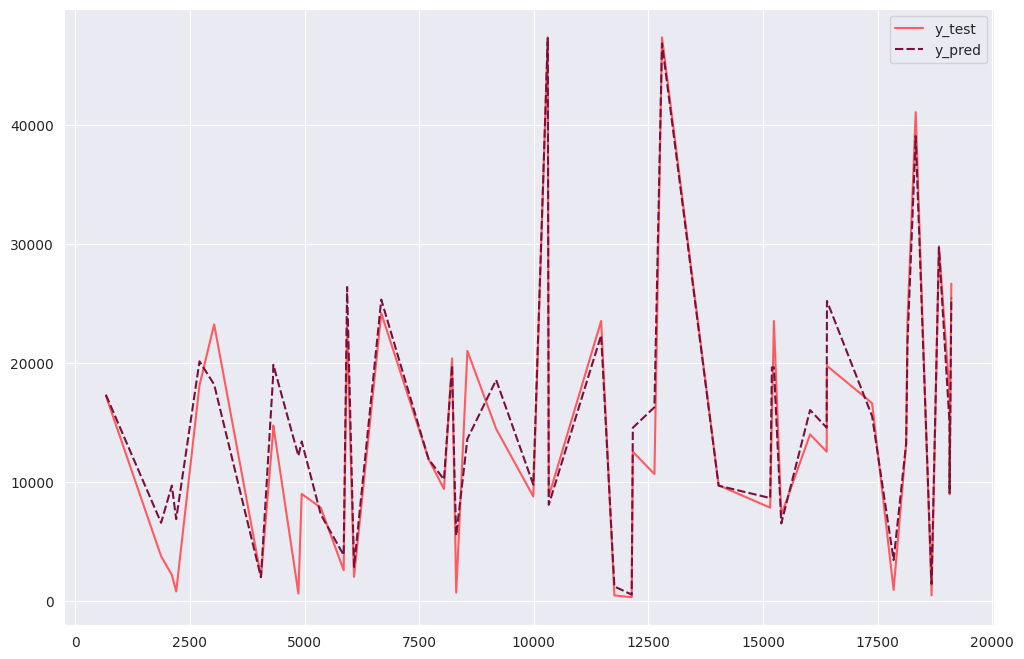

In [146]:
cal_acc(Rf)

### XGB Regressor

In [147]:
xg = XGBRegressor(learning_rate= 0.1,objective='reg:squarederror',max_depth=10,n_estimators = 800,random_state=1)
xg.fit(X_train_scaled, y_train)
# {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

Mean Absolute Error  of the model is : 3310.481
Mean Squared Error of the model is : 33889693.905
Root Mean Squared Error of the model is : 5821.486
R-squared value of the model is : 0.805


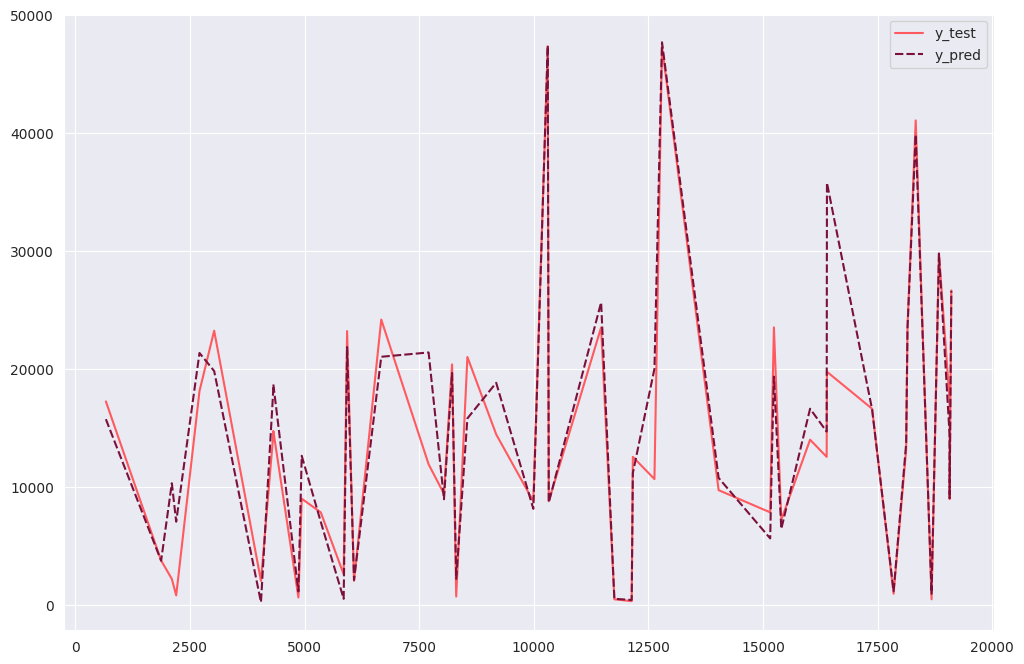

In [148]:
cal_acc(xg)

In [149]:
models= [LinearRegression(),
         KNeighborsRegressor(n_neighbors=6),GradientBoostingRegressor(n_estimators=380,learning_rate=0.4,random_state=1),
         RandomForestRegressor(n_estimators=800, max_depth=20, max_features='log2', random_state=1),
         XGBRegressor(learning_rate= 0.1,objective='reg:squarederror',max_depth=10,n_estimators = 800,random_state=1)]
scores= []
test_score = []
train_score=[]
names= []
MAE=[]
MSE=[]
RMSE=[]

In [150]:
for model in models:
    scores.append(cross_val_score(model, X_train_scaled, y_train, scoring= 'neg_mean_absolute_error', cv= 5).mean())
    names.append(model.__class__.__name__)

df= pd.DataFrame(scores, columns=['Score With Cross-Validation'], index= range(len(models)))
df.insert(0, 'Model', pd.Series(names))

In [151]:
for model in models:
    model.fit(X_train_scaled, y_train)
    score1=model.score(X_train_scaled, y_train)
    train_score.append(score1)    
    score2=model.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    test_score.append(score2)  
    MAE.append(mae)  
    MSE.append(mse)  
    RMSE.append(rmse)  
    

df['Test_Score'] = test_score
df['Train_Score'] = train_score
df['MAE'] = MAE
df['MSE'] = MSE
df['RMSE'] = RMSE

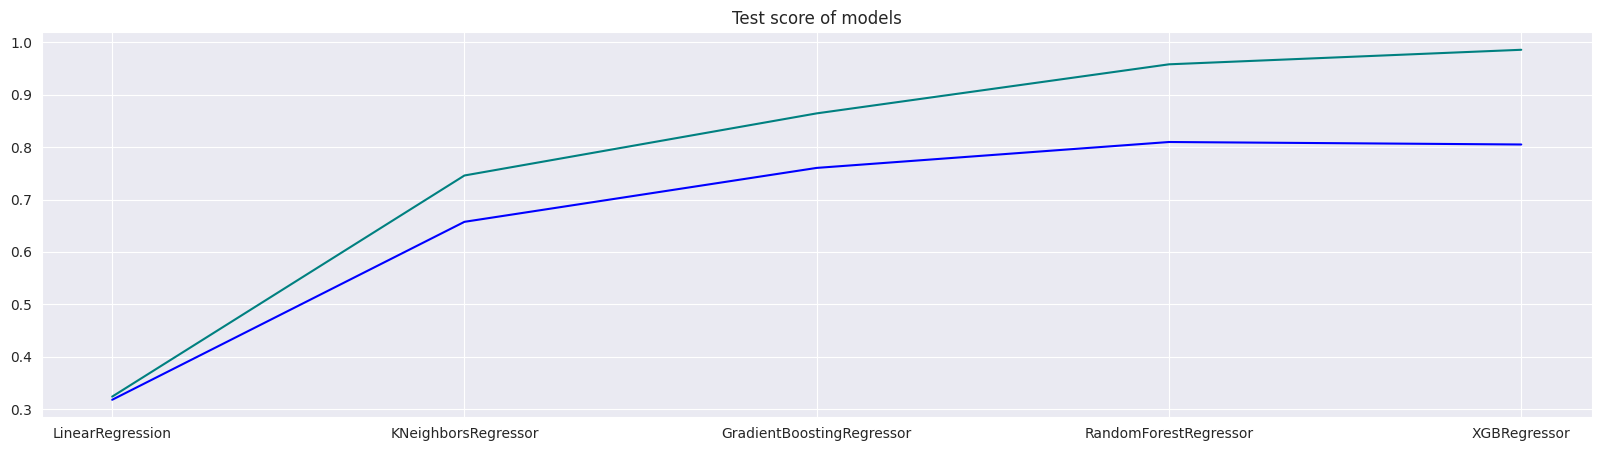

In [152]:
plt.figure(figsize=(20,5))
plt.plot(df['Model'],df['Train_Score'], color='teal')
plt.plot(df['Model'],df['Test_Score'], color='blue')
plt.title('Test score of models')
plt.show();

In [153]:
df

Model  Score With Cross-Validation  Test_Score   
0           LinearRegression                    -8553.904       0.318  \
1        KNeighborsRegressor                    -5262.141       0.657   
2  GradientBoostingRegressor                    -4388.056       0.760   
3      RandomForestRegressor                    -3572.899       0.810   
4               XGBRegressor                    -3493.607       0.805   

   Train_Score      MAE           MSE      RMSE  
0        0.324 8473.734 118576516.807 10889.284  
1        0.746 4746.440  59542085.036  7716.352  
2        0.864 4295.936  41654459.272  6454.027  
3        0.958 3470.496  33062285.460  5749.981  
4        0.986 3310.481  33889693.905  5821.486



*  Based on Cross validation the XGBRegressor	is the best algo


## Pipeline



In [155]:
df=pd.read_csv("data_set/car_price_cleaned.csv")
df.head()

price     levy manufacturer    model   category leather_interior fuel_type   
0  13328 1399.000        LEXUS   RX 450       Jeep              Yes    Hybrid  \
1  16621 1018.000    CHEVROLET  Equinox       Jeep               No    Petrol   
2   8467    0.000        HONDA      FIT  Hatchback               No    Petrol   
3   3607  862.000         FORD   Escape       Jeep              Yes    Hybrid   
4  11726  446.000        HONDA      FIT  Hatchback              Yes    Petrol   

   engine_volume    mileage  cylinders gear_box_type drive_wheels doors   
0          3.500 186005.000      6.000     Automatic          4x4   4-5  \
1          3.000 192000.000      6.000     Tiptronic          4x4   4-5   
2          1.300 200000.000      4.000      Variator        Front   4-5   
3          2.500 168966.000      4.000     Automatic          4x4   4-5   
4          1.300  91901.000      4.000     Automatic        Front   4-5   

              wheel   color  airbags  engine_turbo  age  
0        Left wheel  Silver       12             0   13  
1        Left wheel   Black        8             0   12  
2  Right-hand drive   Black        2             0   17  
3        Left wheel   White        0             0   12  
4        Left wheel  Silver        4             0    9

In [156]:
X=df.drop('price',axis=1)
y = df['price']
X.shape,y.shape
X.drop(['color'],axis=1,inplace=True)

In [157]:
cat_cols=X.select_dtypes(include='object').columns.tolist()
num_cols=X.select_dtypes(include='number').columns.tolist()

In [158]:
num_cols

['levy',
 'engine_volume',
 'mileage',
 'cylinders',
 'airbags',
 'engine_turbo',
 'age']

In [159]:
cat_cols

['manufacturer',
 'model',
 'category',
 'leather_interior',
 'fuel_type',
 'gear_box_type',
 'drive_wheels',
 'doors',
 'wheel']

In [160]:
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size= 0.20 ,random_state=42)

In [161]:
num_pipeline=Pipeline(steps=[
    ('selector',DataFrameSelector(num_cols)),
    ('imputer',SimpleImputer(strategy='median')),
    ('transformer',PowerTransformer(method='yeo-johnson', standardize=True))
])

cat_pipeline=Pipeline(steps=[
    ('selector',DataFrameSelector(cat_cols)),
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('transformer',ce.OrdinalEncoder(drop_invariant=False,return_df=True))
])

# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, ['levy','engine_volume','mileage','cylinders','airbags','engine_turbo','age']),
        ('cat_pipeline', cat_pipeline, ['manufacturer','model','category','leather_interior','fuel_type','gear_box_type','drive_wheels','doors','wheel'])
    ])

# Update the preprocessing pipeline
preprocessing_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

# Define the final pipeline with the model
model_predictor_pipeline = Pipeline(steps=[
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('xgb_regressor_model', XGBRegressor(learning_rate= 0.1,objective='reg:squarederror',max_depth=10,n_estimators = 800,random_state=1))
])

In [162]:
model_predictor_pipeline.fit(X_train, y_train)
y_pred = model_predictor_pipeline.predict(X_test)

In [ ]:
# Predict the target for a single instance
single_instance = pd.DataFrame({
    'doors': ['4/5'],
    'wheel': ['Left'],
    'levy': [1000],
    'engine_volume': [2.0],
    'mileage': [50000],
    'cylinders': [4],
    'airbags': [4],
    'model': ['Corolla'],
    'category': ['Sedan'],
    'leather_interior': ['Yes'],
    'fuel_type': ['Petrol'],
    'gear_box_type': ['Automatic'],
    'drive_wheels': ['4x4'],
    'engine_turbo': [1],
    'age': [3],
    'manufacturer': ['Toyota']
   
})
model_predictor_pipeline.predict(single_instance)

array([47962.355], dtype=float32)

In [ ]:
single_instance

doors wheel  levy  engine_volume  mileage  cylinders  airbags    model  \
0   4/5  Left  1000          2.000    50000          4        4  Corolla   

  category leather_interior fuel_type gear_box_type drive_wheels  \
0    Sedan              Yes    Petrol     Automatic          4x4   

   engine_turbo  age manufacturer  
0             1    3       Toyota

In [ ]:
data=pd.DataFrame([X_test.iloc[20].values],columns=X_test.columns)

In [ ]:
data

levy manufacturer    model category leather_interior fuel_type  \
0 528.000      HYUNDAI  Elantra    Sedan              Yes    Petrol   

   engine_volume   mileage  cylinders gear_box_type drive_wheels doors  \
0          1.600 80856.000      4.000     Automatic        Front   4-5   

        wheel  airbags  engine_turbo   age  
0  Left wheel    4.000         0.000 9.000

In [ ]:
model_predictor_pipeline.predict(data)

array([26109.46], dtype=float32)

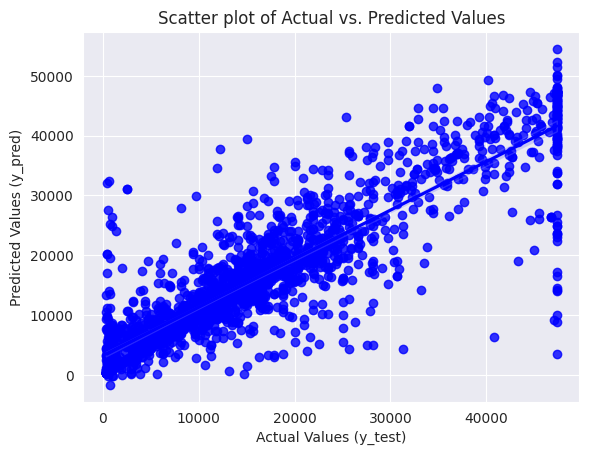

In [ ]:
# Create scatter plot with regression line
sns.regplot(x=y_test.values, y=y_pred,color='blue')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter plot of Actual vs. Predicted Values')
plt.show()

In [ ]:
# Save the final pipeline
joblib.dump(model_predictor_pipeline, 'carPricePredictorModel.pkl')

['carPricePredictorModel.pkl']

In [ ]:
car_model=joblib.load('carPricePredictorModel.pkl')

In [ ]:
y_test.iloc[18]

15530.0

In [ ]:
data=pd.DataFrame([X_test.iloc[18].values],columns=X_test.columns)

In [ ]:
car_model.predict(data)

array([15672.424], dtype=float32)

*App Delopyed*

In [10]:
%%writefile CarPredictorApp.py

import pandas
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import joblib
import pandas as pd
# Define the input data model using BaseModel
from pydantic import BaseModel

class Car(BaseModel):
    doors: str
    wheel: str
    levy: float
    engine_volume: float
    mileage: int
    cylinders: int
    airbags: int
    model: str
    category: str
    leather_interior: str
    fuel_type: str
    gear_box_type: str
    drive_wheels: str
    engine_turbo: int
    age: int
    manufacturer: str

# Define a class for the singleton model loader
class ModelLoader:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = None

    def get_model(self):
        if self.model is None:
            self.model = joblib.load(self.model_path)
        return self.model

# Create an instance of the model loader
car_model_loader = ModelLoader('carPricePredictorModel.pkl')

# origins = [
#     "https://localhost:7192",
#     # Add any other allowed origins here
# ]

# Create a FastAPI application instance
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Endpoint to predict car price
@app.post("/predict")
async def predict_car_price(car: Car):
    try:
        # Convert input data to DataFrame
        df_request = pd.DataFrame([car.dict()])

        # Load the pre-trained model and make a prediction
        model = car_model_loader.get_model()
        prediction = model.predict(df_request)

        # Round the predicted car price to two decimal places
        rounded_price = round(float(prediction[0]), 2)

        return {'message': 'Prediction successful', 'status': 200, "prediction": rounded_price}

    except Exception as e:
        print(e.with_traceback)
        return {"message": f'Please review your request body, maybe it contains invalid data: {str(e)}'}

# Root endpoint
@app.get('/')
async def root():
    return {"message": "Welcome to the Car Price Predictor API"}

Overwriting CarPredictorApp.py


In [8]:
!uvicorn CarPredictorApp:app --reload

INFO:     Will watch for changes in these directories: ['/mnt/3d37937b-ae66-4b53-9163-f354a1f3e7bc/Epsilon Ai sessions for data scenice/Data Science/CarPricePredictor']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [8486] using StatReload
INFO:     Started server process [8488]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:36112 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:36112 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:55878 - "POST /predict HTTP/1.1" 200 OK
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [8488]
INFO:     Started server process [9128]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
^C
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:   

In [9]:
!gunicorn -k uvicorn.workers.UvicornWorker CarPredictorApp:app

[2023-07-06 00:48:31 +0300] [9466] [INFO] Starting gunicorn 20.1.0
[2023-07-06 00:48:31 +0300] [9466] [INFO] Listening at: http://127.0.0.1:8000 (9466)
[2023-07-06 00:48:31 +0300] [9466] [INFO] Using worker: uvicorn.workers.UvicornWorker
[2023-07-06 00:48:31 +0300] [9467] [INFO] Booting worker with pid: 9467
[2023-07-06 00:48:33 +0300] [9467] [INFO] Started server process [9467]
[2023-07-06 00:48:33 +0300] [9467] [INFO] Waiting for application startup.
[2023-07-06 00:48:33 +0300] [9467] [INFO] Application startup complete.
^C
[2023-07-06 00:49:36 +0300] [9466] [INFO] Handling signal: int
[2023-07-06 00:49:36 +0300] [9467] [INFO] Shutting down
[2023-07-06 00:49:36 +0300] [9467] [INFO] Waiting for application shutdown.
[2023-07-06 00:49:36 +0300] [9467] [INFO] Application shutdown complete.
[2023-07-06 00:49:36 +0300] [9467] [INFO] Finished server process [9467]
[2023-07-06 00:49:36 +0300] [9467] [INFO] Worker exiting (pid: 9467)
